 
### Section 1: Business Understanding
In this project we are interested in answering questions regarding the Avocado business and its commercialization. A few of the questions we want to answer are: What are the average prices of avocado in different states?, Do some states have different prices or are the prices the same everywhere?, What is the time of the year with have higher sales or lowest sales? From highest sales of the year, can we figure it out what week was the most profitable, the least? Have the prices have been increasing as years go by or is there a variation?, among many others.

In order to answer some of these possible questions we must have a better understanding of the data we have access to. For this we use open source data that is available to us on the internet in Kagle website. In this site we found data that is related to Avocado prices in United States. Looking at a csv file, we can see data columns such as: average_price, total_volume (Total number of avocados sold), 4046 (Total number of avocados with PLU 4046 sold), 4225 (Total number of avocados with PLU 4225 sold), 4770 (Total number of avocados with PLU 4770 sold), total_bags, small_bags, large_bags, xlarge_bags, type (organic or conventional avocado), year, geography (cities where avocado sales are followed) and month. So far this would be a good starting point to try to answer a few questions.

### Section 2: Data Understanding

In order to answer the questions we might have in mind, we need to understand the data and see what it can reveal to us after we analyze it.

We have our data from internet. We are going to use avocado-prices csv file that we found in [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices).

gather, assess, clean, analyze, model, visualize

First read in the dataset.

#### Gather

In [1895]:
import avocado_functions as t

In [1896]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sb
import avocado_functions as t
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import math
from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
np.random.seed(42)

# df = pd.read_csv('./avocado-updated-2020.csv')
# df.head()

The following code was borrowed from to merge the current dataset with the latest. Special thanks to this [website](https://colab.research.google.com/drive/1UaAqXCY8LJOY3SYmDG6VjZf5YSkwkPRS?usp=sharing)

In [2145]:
# Put csv files with the new data into that directory.
DATASETS_DIR = 'new_avocado_data' 

original_dataset_path = 'avocado-updated-2020.csv'
original_df = pd.read_csv(original_dataset_path, 
                          parse_dates=['date'], 
                          index_col='date')

In [2146]:
import os

# Define a dictionary for renaming names of columns of the new datasets.
RENAMED_COLS_DICT = {
    'asp_current_year': 'average_price',
    'total_bulk_and_bags_units': 'total_volume',
    '4046_units': '4046',
    '4225_units': '4225',
    '4770_units': '4770',
    'totalbagged_units': 'total_bags',
    'smlbagged_units': 'small_bags',
    'lrgbagged_units': 'large_bags',
    'x-lrgbagged_units': 'xlarge_bags'
}

cat_df = original_df.copy()  # a df for concatenating (i.e., merging) the data

print("original dataset's shape:",  original_df.shape)
print()

# Define an accumulatator of the number of entries. This accumulator is used
# for the testing purposes at the bottom of this cell.
n_total_entries_accumulator =  original_df.shape[0]

filenames = sorted(os.listdir(DATASETS_DIR))

for filename in filenames:
    base_filename, extension = filename.split('.')

    if extension != 'csv':
        continue

    else:
        print('processing', filename, '...')

        file_path = os.path.join(DATASETS_DIR, filename)
        tmp_df = pd.read_csv(file_path, 
                             parse_dates=['Current Year Week Ending'], 
                             index_col='Current Year Week Ending')

        print("dataset's shape:", tmp_df.shape)

        tmp_df.drop('Timeframe', axis=1, inplace=True)
        tmp_df.sort_values(['Current Year Week Ending', 'Geography'], inplace=True)
        
        # Lower the columns' names and replace spaces with underscores.
        tmp_df.rename(lambda col_name: col_name.lower().replace(' ', '_'), axis=1, inplace=True)
        tmp_df.rename(RENAMED_COLS_DICT, axis=1, inplace=True)
        tmp_df.index.name = 'date'
        tmp_df.type.replace('Conventional ', 'Conventional', inplace=True)
        assert tmp_df.type.nunique() == 2, 'dataset` must contain only 2 types of avocados'
        
        tmp_df.type = tmp_df.type.apply(lambda avocado_type: avocado_type.lower())
        tmp_df['year'] = tmp_df.index.year

        print('adding', tmp_df.shape[0], 'entries to the original dataset...')
        print()

        cat_df = pd.concat([cat_df, tmp_df], axis=0)
        n_total_entries_accumulator += tmp_df.shape[0]

print("final merged dataset's shape:", cat_df.shape)
print('number of entries in the merged dataset should be:', n_total_entries_accumulator)

assert cat_df.geography.nunique() == 54, 'merged dataset must have 54 unique geographical names'

# Drop all duplicates (if any).
print()
print('dropping duplicates...')

n_entries_before = cat_df.shape[0]
cat_df.drop_duplicates(inplace=True)
n_entries_after = cat_df.shape[0]
n_entries_dropped = n_entries_before - n_entries_after

print(f'dropped {n_entries_dropped} duplicates.')
print("merged dataset's shape after dropping duplicates:", cat_df.shape)

# Sort the merged dataset just in case (not really needed as the data should be 
# already sorted).
cat_df.sort_values(['date', 'geography'], inplace=True)

original dataset's shape: (33045, 12)

processing 2021-plu-total-hab-data.csv ...
dataset's shape: (432, 13)
adding 432 entries to the original dataset...

final merged dataset's shape: (33477, 13)
number of entries in the merged dataset should be: 33477

dropping duplicates...
dropped 0 duplicates.
merged dataset's shape after dropping duplicates: (33477, 13)


In [2147]:
# Save with index as it contains the dates.
cat_df.to_csv('avocado-updated-2021.csv') 

In [2148]:
df = pd.read_csv('./avocado-updated-2021.csv')
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,bulk_gtin
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,NaN
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany,NaN
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta,NaN
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta,NaN
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington,NaN


In [2149]:
df.shape

(33477, 14)

In [2150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33477 entries, 0 to 33476
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           33477 non-null  object 
 1   average_price  33477 non-null  float64
 2   total_volume   33477 non-null  float64
 3   4046           33477 non-null  float64
 4   4225           33477 non-null  float64
 5   4770           33477 non-null  float64
 6   total_bags     33477 non-null  float64
 7   small_bags     33477 non-null  float64
 8   large_bags     33477 non-null  float64
 9   xlarge_bags    33477 non-null  float64
 10  type           33477 non-null  object 
 11  year           33477 non-null  int64  
 12  geography      33477 non-null  object 
 13  bulk_gtin      432 non-null    float64
dtypes: float64(10), int64(1), object(3)
memory usage: 3.6+ MB


We have 3 categorical column values and one int that furthermore will need to be converted to categorical. The rest of the columns are numerical. The last column will need to be removed since it will not be relevant for our analysis.

4046, 4225 and 4770 columns refer to the sizes of avocados sold. These are small, medium and large respectively. Total bags is data associated with the ammount of different sizes avocados bags were sold in a certain period. Type can be either conventional or organic avocado.

Let's just go ahead and remove the last colum

In [2151]:
df = df.drop(columns=['bulk_gtin'])
df.head(2)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,organic,2015,Albany


In [2152]:
df.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
count,33477.000000,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,33477.000000
mean,1.376381,9.734023e+05,3.027129e+05,2.793761e+05,2.152417e+04,3.644869e+05,2.504634e+05,1.062718e+05,7.751660e+03,2017.506557
std,0.379249,3.955361e+06,1.301998e+06,1.149521e+06,1.003468e+05,1.560692e+06,1.037237e+06,5.142241e+05,4.803347e+04,1.735340
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,1.090000,1.528640e+04,7.680200e+02,2.699350e+03,0.000000e+00,9.216350e+03,6.533870e+03,4.683900e+02,0.000000e+00,2016.000000
50%,1.340000,1.300737e+05,1.106115e+04,2.339143e+04,1.747400e+02,5.336299e+04,3.706495e+04,6.385000e+03,0.000000e+00,2017.000000
75%,1.610000,5.088036e+05,1.193483e+05,1.346294e+05,5.032110e+03,1.748443e+05,1.211390e+05,4.041723e+04,8.246900e+02,2019.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2021.000000


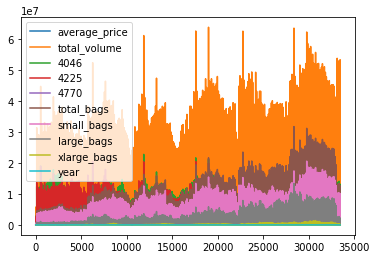

In [2153]:
df.plot.line();

In [2154]:
df.count()

date             33477
average_price    33477
total_volume     33477
4046             33477
4225             33477
4770             33477
total_bags       33477
small_bags       33477
large_bags       33477
xlarge_bags      33477
type             33477
year             33477
geography        33477
dtype: int64

Do we have any null value in our dataset?

In [2155]:
df.isnull().values.any()

False

In [2156]:
# Count the NaN under a single DataFrame column: 
df.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

We dont have any nan values and it seems our data is ready to start working in our analysis.

In [2157]:
df.shape

(33477, 13)

In [2158]:
set(df.columns[df.isnull().mean()==0])

{'4046',
 '4225',
 '4770',
 'average_price',
 'date',
 'geography',
 'large_bags',
 'small_bags',
 'total_bags',
 'total_volume',
 'type',
 'xlarge_bags',
 'year'}

### Section 3: Preparing the Data - Clean and analize

In this dataset we are interested in finding out more about the data and what we can deduce from it. A quick analysis below that will help us in our exploring.

Colums: date, average_price, total_volume, 4046, 4225, 4770, total_bags, small_bags, large_bags, xlarge_bags, type, year, geography.

__*Date*__ can give us information about the evolution of the product throught out time. We can find out if there is an important change in product consumption during a certain time of the year.
 - what is the time of the year that U.S sells more, less avocados?
 - do average price increase during a specific time of the year?
 - is there any preference in consumption size during a certain time of the year?
 - is there a prevalence of type on a certain time?
 - has it always been the case the size had a direct impact on prices fluctuation?
 
__*average_price*__
 - are average prices related to geography?
 - are there regions that have a tendency to have higher prices?
 - is there a strong realation to the type of product and price?
 - what is the tendency in prices over time. Have they increased, decreased?
 
__*total_volume*__
 - when was the highest sale of the product
 - at what price did the biggest sale occurred? the smallest?
 - in what region did the biggest, smallest sale took place. 
 
__*4046, 4225, 4770*__ are the sizes of the avocados: small, medium and large respectively.
 - what is the most popular size?
 - is there a place where a specific size is more popular than others?
 - is there a time of the year that one size is more prevalent than others?
 
__*type*__ conventional and organic
 - overall is one product preferred over the other?
 - what are the locations of preference of both products?
 - what is the price relationship to these types?
 
Now we will start analysing the data to answer some of these questions and have a broader understanding of our dataset.

In [2159]:
# work here in visual representation of the data

In [2160]:
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [2161]:
# #create a dataframe of each string you want to search for in each row
# def total_count(df, col1, col2, look_for):
#     '''
#     INPUT:
#     df - the pandas dataframe you want to search
#     col1 - the column name you want to look through
#     col2 - the column you want to count values from
#     look_for - a list of strings you want to search for in each row of df[col]

#     OUTPUT:
#     new_df - a dataframe of each look_for with the count of how often it shows up
#     '''
#     new_df = defaultdict(int)
#     #loop through list of ed types
#     for val in look_for:
#         #loop through rows
#         for idx in range(df.shape[0]):
#             #if the ed type is in the row add 1
#             if val in df[col1][idx]:
#                 new_df[val] += int(df[col2][idx])
#     new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
#     new_df.columns = [col1, col2]
#     new_df.sort_values('count', ascending=False, inplace=True)
#     return new_df


In [2162]:
#function to clean data and plot
# def clean_plot(df, title, col_name, look_for, plot):  
#     '''
#         INPUT 
#             df - a dataframe holding the interested column
#             title - string the title of your plot
#             axis - axis object
#             plot - bool providing whether or not you want a plot back

#         OUTPUT
#             study_df - a dataframe with the count of how many individuals
#             Displays a plot of pretty things related to the interested column column.
#     '''
#     clean = df[col_name].value_counts().reset_index()
#     clean.rename(columns={'index': 'ammount', col_name: 'count'}, inplace=True)
#     clean_lf = total_count(clean, 'ammount', 'count', look_for)
#     clean_lf.set_index('ammount', inplace=True)
#     if plot:
#         (clean_lf/clean_lf.sum()).plot(kind='bar', legend=None);
#         plt.title(title);
#         plt.show()
#     props_clean_lf = clean_lf/clean_lf.sum()
#     return props_clean_lf

In [2163]:
# df['average_price'] =df['average_price'].apply(clean_currency).astype('str')
# look_for = ['0.25', '0.50', '0.75', '1', '1.10', '1.20', '1.25', '1.30', '1.40','1.50', '1.75', '2', '2.25', '2.50', '2.75', '3.00', '3.25', '3.50']
# props_clean_price = clean_plot(df, 'Average Price', 'average_price', look_for, True)

In [2164]:
df.sort_values(["average_price", "year"], ascending=[True, False]) 

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
12222,2017-03-05,0.44,64057.04,223.84,4748.88,0.00,59084.32,638.68,58445.64,0.00,organic,2017,Cincinnati/Dayton
11837,2017-02-05,0.46,2200550.27,1200632.86,531226.65,18324.93,450365.83,113752.17,330583.10,6030.56,conventional,2017,Phoenix/Tucson
12230,2017-03-05,0.48,50890.73,717.57,4138.84,0.00,46034.32,1385.06,44649.26,0.00,organic,2017,Detroit
12114,2017-02-26,0.49,44024.03,252.79,4472.68,0.00,39298.56,600.00,38698.56,0.00,organic,2017,Cincinnati/Dayton
5573,2015-12-27,0.49,1137707.43,738314.80,286858.37,11642.46,100891.80,70749.02,30142.78,0.00,conventional,2015,Phoenix/Tucson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14976,2017-08-27,3.04,12656.32,419.06,4851.90,145.09,7240.27,6960.97,279.30,0.00,organic,2017,Raleigh/Greensboro
12360,2017-03-12,3.05,2068.26,1043.83,77.36,0.00,947.07,926.67,20.40,0.00,organic,2017,Miami/Ft. Lauderdale
10452,2016-11-06,3.12,19043.80,5898.49,10039.34,0.00,3105.97,3079.30,26.67,0.00,organic,2016,San Francisco
12952,2017-04-16,3.17,3018.56,1255.55,82.31,0.00,1680.70,1542.22,138.48,0.00,organic,2017,Tampa


In [2165]:
# According to avocado sizes, which group has the highest average price?
x = df.groupby(['4046', '4225', '4770']).mean()['average_price'].sort_values()
x

4046        4225       4770    
223.84      4748.88    0.00        0.44
1200632.86  531226.65  18324.93    0.46
717.57      4138.84    0.00        0.48
252.79      4472.68    0.00        0.49
738314.80   286858.37  11642.46    0.49
                                   ... 
419.06      4851.90    145.09      3.04
1043.83     77.36      0.00        3.05
5898.49     10039.34   0.00        3.12
1255.55     82.31      0.00        3.17
2325.93     11142.85   0.00        3.25
Name: average_price, Length: 33366, dtype: float64

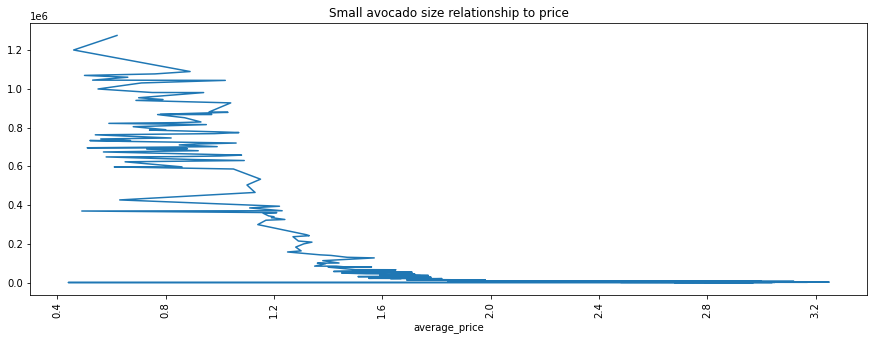

In [2166]:
# what is the small avocado relationship to average price
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator('auto'))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))

plt.title("Small avocado size relationship to price")
df.groupby(['average_price']).mean()['4046'].sort_values().plot();
plt.xticks(rotation = 90);

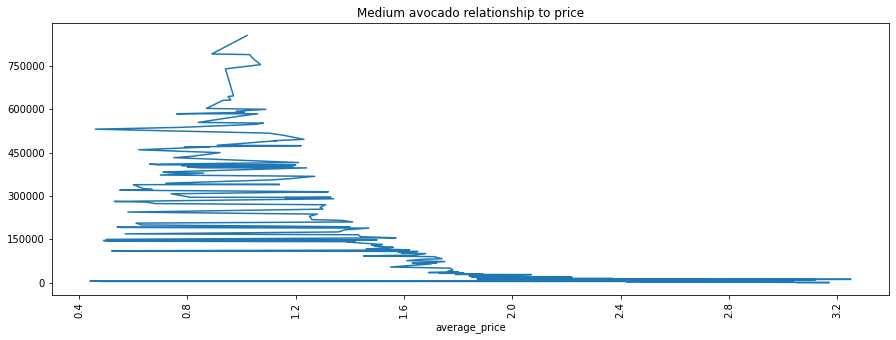

In [2167]:
# what is the medium avocado relationship to average price
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator('auto'))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))

plt.title("Medium avocado relationship to price")
df.groupby(['average_price']).mean()['4225'].sort_values().plot();
plt.xticks(rotation = 90);

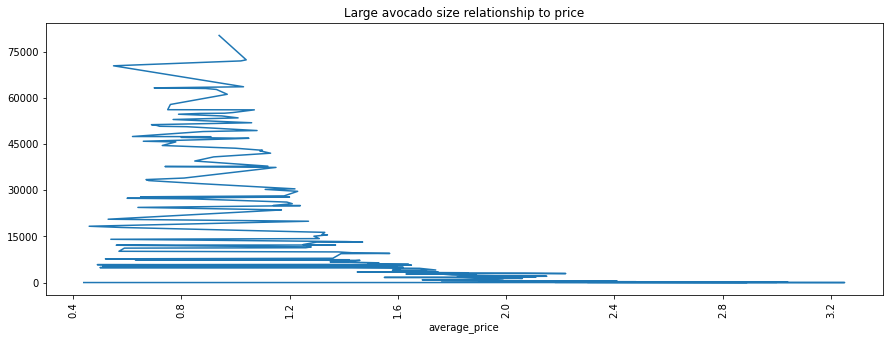

In [2168]:
# what is the large avocado relationship to average price
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator('auto'))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))

plt.title("Large avocado size relationship to price")
df.groupby(['average_price']).mean()['4770'].sort_values().plot();
plt.xticks(rotation = 90);

It seems that small avocado average prices in its majority fluctuates between 0.8 and 1.5 usd aproximately. This sise of avocados is the one that presents highest sales.

Medium avocados have its breaking point about 1.7. Anytime the price goes above this mark sales tend to decrease.

Large avocados have their majority on its sales when prices drop. Generaly when prices go over 1.7 the sales decrease dramatically just as medium size do.

We are also interested in what are the most common prices that all avocados sizes get sold at?

In [2169]:
# What are the most common prices that all avocados sizes get sold at
x = df.groupby(['4046', '4225','4770']).mean()[ 'average_price'].sort_values()

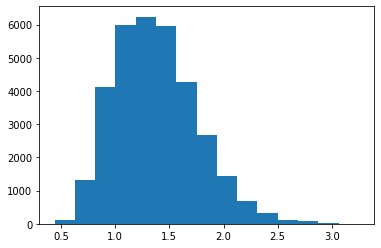

In [2170]:
plt.hist(x, bins=15);

The majority of avocados get sold in a range from 0.75 and 1.8 usd approximaltely. This information is important because if we were to get into the avocado bussiness we can calculate our profits expectation according to our supply of product at hand.

What year were avocados the most expensive? What is the tendency evern since year 2015?

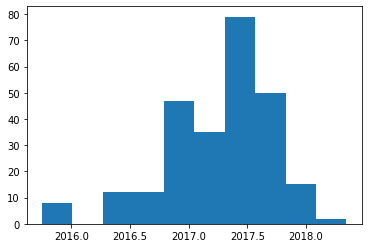

In [2171]:
x = df.groupby(['average_price']).mean()['year'].sort_values()
plt.hist(x);

It seems average prices were higher in year 2017. The tendency of prices was increasing steadily up until year 2017 when prices scaled up considerably. After 2017 the prices show an steep decrease up until now, therefore the tendency up until April 2021 is a decline in the prices. Let's not forget to mention that we had COVID pandemia in 2020, which could or should be one of the greatest inflence in this tendency.

In [2172]:
type(df['average_price'][0])

numpy.float64

In [2173]:
type(df['geography'][0])

str

In [2174]:
df['average_price'] =df['average_price'].apply(clean_currency).astype('float')

In [2175]:
type(df['average_price'][0])

numpy.float64

In what parts of the country avocado prices are the highest and the lowest?

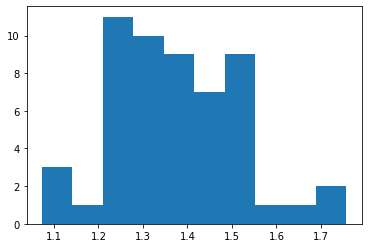

In [2176]:
# is there a big difference between average prices by location?
# in what region did the biggest, smallest sale took place.
region_prices = df.groupby(['geography']).mean()['average_price'].sort_values()
plt.hist(region_prices);

In [2177]:
region_prices

geography
Dallas/Ft. Worth        1.073419
Houston                 1.073484
South Central           1.102484
Phoenix/Tucson          1.205677
Nashville               1.214984
Columbus                1.218113
New Orleans/Mobile      1.225597
Roanoke                 1.230161
Cincinnati/Dayton       1.235935
Richmond/Norfolk        1.244565
West Tex/New Mexico     1.248622
Detroit                 1.251065
Indianapolis            1.256129
Denver                  1.259290
Louisville              1.267355
Tampa                   1.293968
Atlanta                 1.300242
Great Lakes             1.307500
Los Angeles             1.310839
West                    1.320242
Total U.S.              1.320871
Southeast               1.322016
Pittsburgh              1.324984
Miami/Ft. Lauderdale    1.334387
Plains                  1.346371
Orlando                 1.354677
Las Vegas               1.354887
South Carolina          1.362661
Midsouth                1.368968
Jacksonville            1.381516


The three highest prices are in New York, Hartford/Springfield ans San Francisco. The lowest are Dallas/Ft. Worth, Houston and South Central. Suth Central is a region that includes the states of Arkansas, Louisiana, Oklahoma, and Texas.

The highest average prices of avocados are found in San Francisco and the lowests are in Dallas/Ft. Worth. The difference in average price is $0.68 usd

We are interested to know at what prices in general were the most ammount of avocados sold according to our dataset.

In [2178]:
s = df.groupby(['average_price']).mean()['total_volume'].sort_values()
s

average_price
3.05    2.068260e+03
2.95    2.417550e+03
3.17    3.018560e+03
3.03    3.714710e+03
2.91    4.103970e+03
            ...     
0.66    2.743026e+06
1.04    2.759713e+06
0.94    2.940731e+06
1.02    2.961101e+06
0.89    3.154869e+06
Name: total_volume, Length: 260, dtype: float64

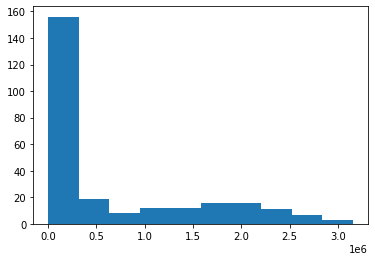

In [2179]:
plt.hist(s);

The highest volume of avocados where sold when the average price was 0.89 usd per unit. The least ammount of avocados were sold when the price was 3.05 usd per unit.

We want to know if there is any tendency in prices associated with month and year.

In [2180]:
df.groupby(['date']).mean()['total_volume'].sort_values()

date
2016-10-30    5.292655e+05
2018-11-25    5.649694e+05
2015-11-29    5.692443e+05
2016-11-06    5.722733e+05
2016-11-27    5.847638e+05
                  ...     
2018-02-04    1.566461e+06
2019-02-03    1.569369e+06
2020-05-03    1.572185e+06
2018-05-06    1.598463e+06
2020-02-02    1.600011e+06
Name: total_volume, Length: 310, dtype: float64

In [2181]:
df.groupby(['date']).mean()['average_price'].sort_values()

date
2021-01-04    1.050370
2021-01-24    1.104630
2021-01-10    1.117963
2020-02-02    1.131389
2019-02-03    1.138796
                ...   
2017-09-24    1.833333
2017-10-08    1.843333
2017-09-10    1.843889
2017-09-03    1.855185
2017-10-01    1.871296
Name: average_price, Length: 310, dtype: float64

In February 2020 we can see that there was the highest sale of avocados, followed by May 2018 and March 2020. The lowest wast on October 2016, followed by November 2018.

The year that we experienced highest prices was in 2017, while the lowest so far seems to be January this year. This document is written in April 2021.

what have been the averages prices per year?

In [2182]:
# x = df.groupby(['geography']).mean()['average_price'].sort_values()
# plt.hist(x);

In [2183]:
#  sb.countplot(data=df, x='geography');

In [2184]:
# end of visualization. Work above needs more work and findng better graphs

In [2185]:
# df.average_price.plot(kind="hist")

We know think we can get more information if we have month as one of our columns. We already have the year.

In [2186]:
type(df['date'][0])

str

In [2187]:
df['date'] = pd.to_datetime(df['date'])

In [2188]:
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [2189]:
df['date'][0]

Timestamp('2015-01-04 00:00:00')

In [2190]:
# get the month of the date - we already a the year in a column
df['month'] = df['date'].dt.month

In [2191]:
df.head(2)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1
1,2015-01-04,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,organic,2015,Albany,1


In [2192]:
# remove date column we dont need it anymore
# df = df.drop(['date'], axis=1)

In [2193]:
df.head(2)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1
1,2015-01-04,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,organic,2015,Albany,1


In [2194]:
df.shape

(33477, 14)

What is the month of the year that U.S sells more and less avocados?

In [2195]:
# what was the month of the year that U.S sold more and less avocados?
df.groupby(['year', 'month']).mean()['total_volume'].sort_values()

year  month
2016  11       6.023364e+05
2017  9        6.592119e+05
2016  10       6.670404e+05
2017  10       6.718110e+05
2015  11       6.841482e+05
                   ...     
2020  8        1.287638e+06
      7        1.342336e+06
2021  1        1.356068e+06
2020  6        1.359096e+06
      5        1.458038e+06
Name: total_volume, Length: 72, dtype: float64

May 2020 was the date that U.S. sold most avocados and October 2016 was the date with the least avocados sold.

In [2196]:
# Let's see what is the total volume association with sales by year
df.groupby(['year']).mean()['total_volume'].sort_values()

year
2015    7.810274e+05
2016    8.584206e+05
2017    8.623393e+05
2019    1.036816e+06
2018    1.040919e+06
2020    1.259413e+06
2021    1.356068e+06
Name: total_volume, dtype: float64

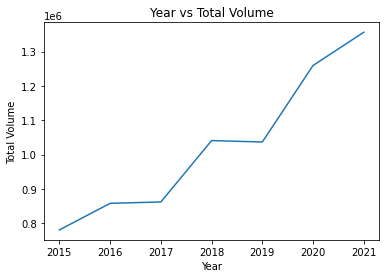

In [2197]:
plt.title("Year vs Total Volume")
plt.xlabel('Year')
plt.ylabel('Total Volume')
plt.plot(df[["year", "total_volume"]].groupby("year").mean());
# plt.plot(df.groupby(['year']).mean()['total_volume'].sort_values());

In [2198]:
# Let's see what is the total volume association with sales by month
df.groupby(['month']).mean()['total_volume'].sort_values()

month
12    8.076695e+05
11    8.223470e+05
10    8.446863e+05
9     9.064773e+05
8     9.499249e+05
7     9.832681e+05
3     9.957150e+05
4     1.016582e+06
1     1.033152e+06
6     1.051247e+06
2     1.095374e+06
5     1.123632e+06
Name: total_volume, dtype: float64

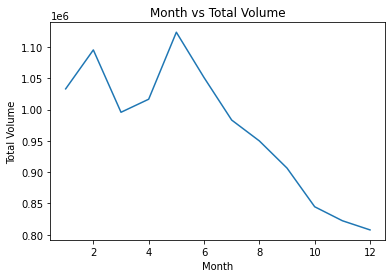

In [2199]:
plt.title("Month vs Total Volume")
plt.xlabel('Month')
plt.ylabel('Total Volume')
plt.plot(df[["month", "total_volume"]].groupby("month").mean());

The result above is consistent with our previous results. We observe that the highest volume of sales was in 2021 with 1.356068e+06 units sold, this makes sense since 2021 we also had the lowest prices. As prices decreases volume of sales increases.

It looks like the total amount of sales have been increasing each year, with the exception of of year 2018. 2021 shows to be the year up until march that has have the most ammount of sales so far since 2015. 2018 had more sales than 2019. The data also shows that May is the month that hast most sale volume followed by February.
The year that had less sales was 2015 and the month with less total volume is December followed by November.

The lowest ammount of sales was in 2015, followed by 2016. 

May, February and June seems to be the best months for sales, while December, November and October are the slowest.

But what about average prices per year or month?

In [2200]:
df[["year", "average_price"]].groupby("year").mean()

,average_price
year,
2015,1.375590
2016,1.338640
2017,1.515128
2018,1.355019
2019,1.401505
2020,1.282259
2021,1.104097


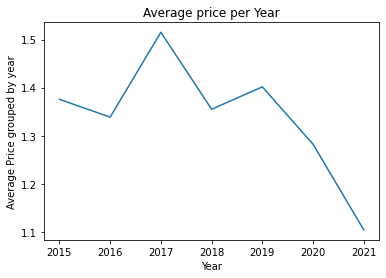

In [2201]:
plt.title("Average price per Year")
plt.xlabel('Year')
plt.ylabel('Average Price grouped by year')
plt.plot(df[["year", "average_price"]].groupby("year").mean());

In [2202]:
# what is the tendency in prices over time. Have they increased, decreased?
df.groupby(['month']).mean()['average_price'].sort_values()

month
2     1.248885
1     1.263919
3     1.316207
12    1.321063
11    1.361806
5     1.362226
4     1.374765
6     1.403636
10    1.448109
7     1.457877
8     1.470107
9     1.485673
Name: average_price, dtype: float64

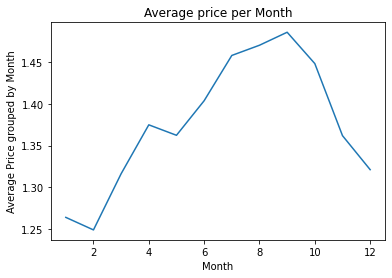

In [2203]:
plt.title("Average price per Month")
plt.xlabel('Month')
plt.ylabel('Average Price grouped by Month')
plt.plot(df[["month", "average_price"]].groupby("month").mean());

Prices have been decreasing steadily since 2019 and again the graph shows that highest avocado prices seen were in 2019. July, August, September aproximatedly show to have the highest prices in general. 

Our graph show us that prices have been having a tendency to decrease ever since 2015. We can also see that since 2015 the highest average prices were in 2017. As prices decline total volume of sales increase.

Next, We would like to know what is the avocado size that sells the most

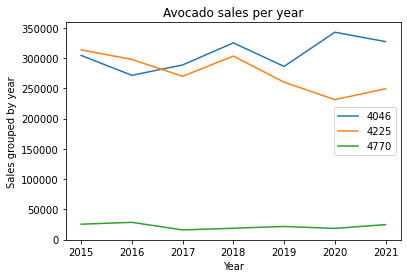

In [2204]:
plt.title("Avocado sales per year")
plt.xlabel('Year')
plt.ylabel('Sales grouped by year')
plt.plot(df[["year", "4046"]].groupby("year").mean(), label = '4046');
plt.plot(df[["year", '4225']].groupby("year").mean(), label = '4225');
plt.plot(df[["year", '4770']].groupby("year").mean(),  label = '4770');
plt.legend();

Small size avocadoes (4046) sell the most and medium size (4225) sell the least.

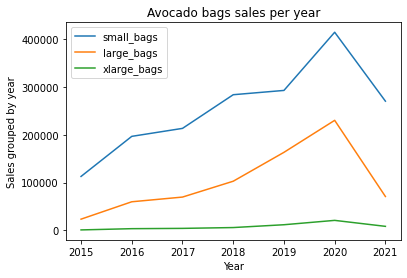

In [2205]:
plt.title("Avocado bags sales per year")
plt.xlabel('Year')
plt.ylabel('Sales grouped by year')
plt.plot(df[["year", "small_bags"]].groupby("year").mean(), label = 'small_bags');
plt.plot(df[["year", 'large_bags']].groupby("year").mean(), label = 'large_bags');
plt.plot(df[["year", 'xlarge_bags']].groupby("year").mean(),  label = 'xlarge_bags');
plt.legend();

Again, small bags is what is most populat for sale.

In [2206]:
# find relationship by month
df.groupby(['month']).mean()['total_volume'].sort_values()

month
12    8.076695e+05
11    8.223470e+05
10    8.446863e+05
9     9.064773e+05
8     9.499249e+05
7     9.832681e+05
3     9.957150e+05
4     1.016582e+06
1     1.033152e+06
6     1.051247e+06
2     1.095374e+06
5     1.123632e+06
Name: total_volume, dtype: float64

In [2207]:
# do average price increase during a specific time of the year?
df.groupby(['year']).mean()['average_price'].sort_values()

year
2021    1.104097
2020    1.282259
2016    1.338640
2018    1.355019
2015    1.375590
2019    1.401505
2017    1.515128
Name: average_price, dtype: float64

In [2208]:
# what is the tendency in prices over time. Have they increased, decreased?
df.groupby(['month']).mean()['average_price'].sort_values()

month
2     1.248885
1     1.263919
3     1.316207
12    1.321063
11    1.361806
5     1.362226
4     1.374765
6     1.403636
10    1.448109
7     1.457877
8     1.470107
9     1.485673
Name: average_price, dtype: float64

September shows to hold the higher prices in average, followed by August and July.. The lowest prices in general of our dataset is February.

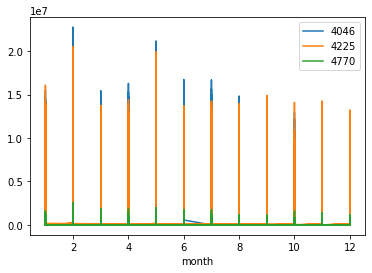

In [2209]:
# what is the most popular size?
df.plot(x="month", y=['4046', '4225', '4770'], kind='line');

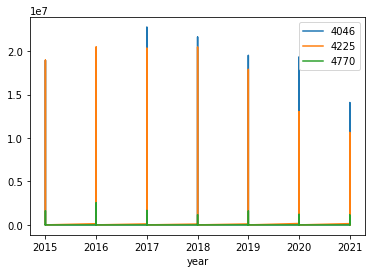

In [2210]:
df.plot(x="year", y=['4046', '4225', '4770'], kind='line');

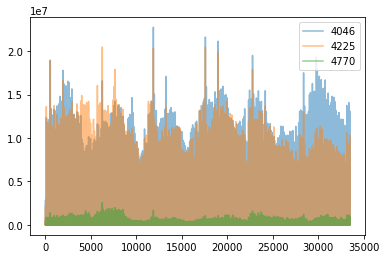

In [2211]:
# create df from size colums 
size_avocados_df = df[['4046', '4225', '4770']].copy()
size_avocados_df.plot.line(alpha=0.5);

We can observe that the most popular size sold since year 2015 until 2021 is PLU 4046. The least sold is extra large with PLU 4770. Therefore the most popular size is small avocado. The smalles size avocado is generally from February-July and medium size the rest of the year.

In [2212]:
# has it always been the case the size had a direct impact on prices fluctuation?
df.groupby(['4046']).mean()['average_price'].sort_values()

4046
223.84        0.44
1200632.86    0.46
717.57        0.48
738314.80     0.49
1069350.16    0.50
              ... 
419.06        3.04
1043.83       3.05
5898.49       3.12
1255.55       3.17
2325.93       3.25
Name: average_price, Length: 31993, dtype: float64

In [2213]:
# is there a strong relation to the type of product and price?
df.groupby(['type']).mean()['average_price'].sort_values()

type
conventional    1.141474
organic         1.611331
Name: average_price, dtype: float64

In [2214]:
# what type of avocado sells more
df.groupby(['type']).mean()['total_volume'].sort_values()

type
organic         6.441855e+04
conventional    1.882223e+06
Name: total_volume, dtype: float64

In [2215]:
# overall is one product preferred over the other?
df.groupby(['type', 'year']).mean()['total_volume'].sort_values()

type          year
organic       2015    3.165993e+04
              2016    4.652424e+04
              2017    5.879018e+04
              2019    7.262982e+04
              2018    7.695845e+04
              2020    9.894945e+04
              2021    1.225478e+05
conventional  2015    1.530128e+06
              2017    1.665327e+06
              2016    1.670317e+06
              2019    2.001003e+06
              2018    2.004880e+06
              2020    2.419877e+06
              2021    2.589589e+06
Name: total_volume, dtype: float64

Organic type avocado has generally a higher price than conventional. Conventional avocados sell more than organic.

In [2216]:
df.groupby(['type', 'year']).mean()['average_price'].sort_values()

type          year
conventional  2021    0.891944
              2020    1.051420
              2015    1.077963
              2016    1.105595
              2018    1.141092
              2019    1.187179
              2017    1.294888
organic       2021    1.316250
              2020    1.513098
              2018    1.568946
              2016    1.571684
              2019    1.615830
              2015    1.673324
              2017    1.735521
Name: average_price, dtype: float64

Non organic avocado has been the most sold type in comparison with organic fron 2015-2021 and the price of organic has always been higher.

Notice that we did not need to do any predictive modeling for the analysis above. We only used descriptive and a little inferential statistics to retrieve the results. We do have a greater understanding now about our data though. The next step for us is to predict prices of avocadoes.

If a person decides to go into avocado bussiness will be important to understand what statistics can predict about the price of the product. We want to know what we expect the price to be, the total volume we expect to sell at a certain time of the year, the price most likely we will want to charge, etc. All this information prior hand can make a a big difference in the planing of a bussiness venture, we would want to know if we have a competitive advantage or disadvantage while considering all variables associated with a bussiness.

In the next part of the analysis we are going to look at the categorical variables that we did not use much in our descriptive analysis. We are interested in Geography column, since this data has the name of the regions were the sales took place. Mostly we are interested in California state, because this is the place we will want to have a avocado plantation or maybe buy avocados and distribute to the population. 

California state in our dataset has 4 cities that we will focus on: Los Angeles, Sacramento, San Diego and San Francisco. We will like to know which it seems to be the best place for us to sell avocadoes. Would also like to know what prices we can charge at certain times os the year and more or less see what machine learning models can tell us about the the data and its predictions.

Let's look at this categorical column and see what it tell us. Next it looks though that we will have to separate it different columns and create a matrix for analysis. 

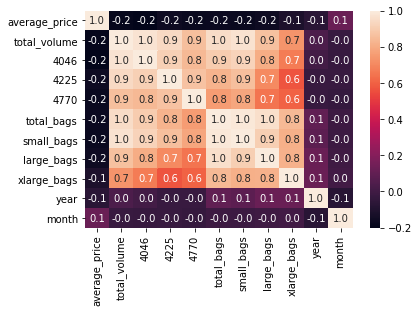

In [2217]:
sb.heatmap(df.corr(), annot=True, fmt=".1f");

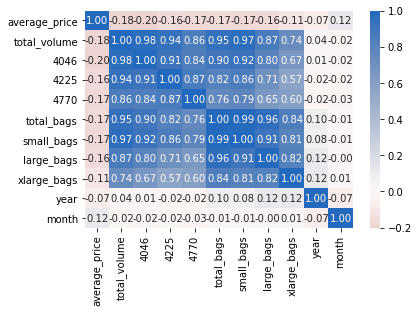

In [2218]:
sb.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0);

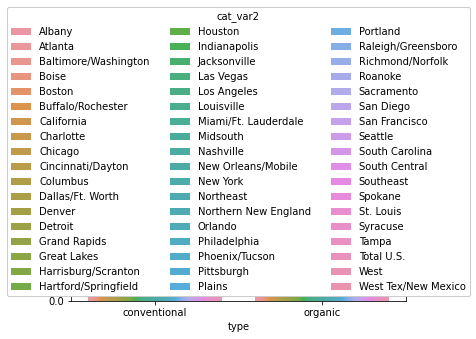

In [2219]:
ax = sb.barplot(data = df, x = 'type', y = 'average_price', hue = 'geography')
ax.legend(loc = 8, ncol = 3, framealpha = 1, title = 'cat_var2');

Next we move our quantitative variables to an X matrix, which we will use to predict our response. We also create our response. We then split our data into training and testing data.

In our first try we are going to look at the r-square value that we get. This is going to be an important data that we will get and will tell us how well our model is doing.

The actual calculation of R-squared requires several steps though. This includes taking the data points of dependent (y) and independent variables (x) and finding the line of best fit that we will get from our model. Then we can calculate predicted values, subtract actual values and square the results. This will give us a list of errors squared, which we are going to sum and equalize it to the unexplained variance.

To calculate the total variance, we will subtract the average actual value from each of the actual values, then we will square them and sum. We will then divide the first sum of errors by the second sum to finally subtract the results. This is going to give us the r-squared. 

In [2221]:
df.head(1) 

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month
0,2015-01-04,1.22,40873.28,2819.5,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1


In [2222]:
#Split into explanatory and response variables
X = df[['total_volume', '4046', '4225','4770','total_bags','small_bags','large_bags','xlarge_bags']]
y = df['average_price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.050890351171417714 on 10044 values.'

In [2223]:
 mean_squared_error(y_test, y_test_preds)

0.13756900553777276

In [2224]:
# Function to calculate prediction vs actual values. Done so we can graph 
# our results
def preds_vs_act(y_test, y_test_preds):
    '''
    INPUT:
    y_test -the panda Series that we are testing
    y_test_preds - the test array that we are predicting
     
    OUTPUT:
    pva - a dataframe that holds the differences between our tests
    '''
    pva = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
    pva.columns = ['actual', 'preds']
    pva['diff'] = pva['actual'] - pva['preds']
    return pva

In [2225]:
quant_vars = preds_vs_act(y_test, y_test_preds)
quant_vars.head()

,actual,preds,diff
0,1.32,1.393584,-0.073584
1,1.51,1.393506,0.116494
2,1.69,1.393352,0.296648
3,1.67,1.393764,0.276236
4,2.17,1.393962,0.776038


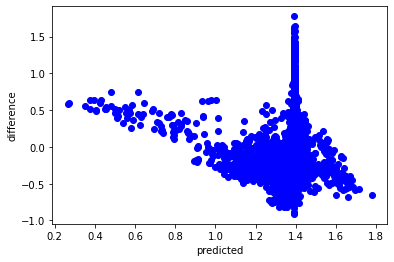

In [2226]:
plt.plot(quant_vars['preds'], quant_vars['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

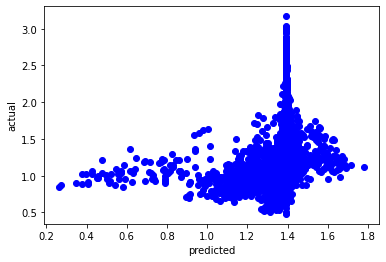

In [2227]:
plt.plot(quant_vars['preds'], quant_vars['actual'], 'bo');
plt.xlabel('predicted');
plt.ylabel('actual'); #This looks less compelling that we are predicting well.

we built a model that predicts... but we are missing by ALOT!
A r-squared error value of 0.050 suggests that 5% of the variability in prices can be explained by these variables.
The Rsquared value is the square of the correlation coefficient.

A common definition for the Rsquared variable is that it is the amount of variability in the response variable that can be explained by the x-variable in our model. In general, the closer this value is to 1, the better our model fits the data.

We can see about how well our model perform in our test data. But we see that the r-quared value is not as good as we would expected. We will now see if we can do better by adding categorical values to our model. We could do this by creating an X matrix that would (potentially) allow us to predict better than just the numeric columns we have been using thus far.

In [2228]:
df.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year,month
count,33477.000000,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,3.347700e+04,33477.000000,33477.000000
mean,1.376381,9.734023e+05,3.027129e+05,2.793761e+05,2.152417e+04,3.644869e+05,2.504634e+05,1.062718e+05,7.751660e+03,2017.506557,6.303074
std,0.379249,3.955361e+06,1.301998e+06,1.149521e+06,1.003468e+05,1.560692e+06,1.037237e+06,5.142241e+05,4.803347e+04,1.735340,3.417048
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000,1.000000
25%,1.090000,1.528640e+04,7.680200e+02,2.699350e+03,0.000000e+00,9.216350e+03,6.533870e+03,4.683900e+02,0.000000e+00,2016.000000,3.000000
50%,1.340000,1.300737e+05,1.106115e+04,2.339143e+04,1.747400e+02,5.336299e+04,3.706495e+04,6.385000e+03,0.000000e+00,2017.000000,6.000000
75%,1.610000,5.088036e+05,1.193483e+05,1.346294e+05,5.032110e+03,1.748443e+05,1.211390e+05,4.041723e+04,8.246900e+02,2019.000000,9.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2021.000000,12.000000


In [2229]:
print(type(df['year'][0]),type(df['month'][0]))

<class 'numpy.int64'> <class 'numpy.int64'>


In [2230]:
# Let's convert month and year type to string
df['year'] =df['year'].apply(clean_currency).astype('str')
df['month'] =df['month'].apply(clean_currency).astype('str')

In [2231]:
print(type(df['year'][0]),type(df['month'][0]), type(df['geography'][0]))

<class 'str'> <class 'str'> <class 'str'>


In [2232]:
# Subset to a dataframe only holding the categorical columns
cat_df = df.select_dtypes(include=['object']) 

# Print how many categorical columns are in the dataframe
cat_df.shape[1]

4

In [2233]:
np.sum(np.sum(cat_df.isnull())/cat_df.shape[0] == 0)

4

In [2234]:
cat_df.head()

,type,year,geography,month
0,conventional,2015,Albany,1
1,organic,2015,Albany,1
2,conventional,2015,Atlanta,1
3,organic,2015,Atlanta,1
4,conventional,2015,Baltimore/Washington,1


For each of the categorical variables, we now need to create dummy columns.

In [2235]:
cat_df.columns

Index(['type', 'year', 'geography', 'month'], dtype='object')

In [2236]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [2237]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False) #Use your newly created function
# show the new df
df_new.head(2)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-04,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [2238]:
df_new.shape

(33477, 81)

In [2239]:
# later on we are going to need the names of the columns to be without
# spaces or dots, let's just rename them now.
df_new.columns = ['date','average_price', 'total_volume', 'small_size', 'medium_size', 'large_size', 'total_bags',
       'small_bags', 'large_bags', 'xlarge_bags', 'type_organic', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'geography_Atlanta', 'geography_Baltimore_Washington',
       'geography_Boise', 'geography_Boston', 'geography_Buffalo_Rochester',
       'geography_California', 'geography_Charlotte', 'geography_Chicago',
       'geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando',
       'geography_Philadelphia', 'geography_Phoenix_Tucson',
       'geography_Pittsburgh', 'geography_Plains', 'geography_Portland',
       'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento', 'geography_SanDiego',
       'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_SouthCentral',
       'geography_Southeast', 'geography_Spokane', 'geography_StLouis',
       'geography_Syracuse', 'geography_Tampa', 'geography_TotalUS',
       'geography_West', 'geography_WestTex_NewMexico', 'month_10',
       'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9']


we will also want to remove total_us sales as well as columns representing the sales by state. These columns will have reduntant sales information that can potentially cause issues in our models and predictions. We also want to get rid of date since we already have month and year in our matrix. We will not need it for this analysis

In [2240]:
df_new = df_new.drop(['date','geography_TotalUS', 'geography_California', 'geography_NorthernNewEngland', 'geography_Plains', 'geography_SouthCentral', 'geography_Southeast', 'geography_West', 'geography_WestTex_NewMexico', 'geography_Hartford_Springfield'], axis=1)
df_new.shape

(33477, 71)

In [2241]:
df_new.columns

Index(['average_price', 'total_volume', 'small_size', 'medium_size',
       'large_size', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type_organic', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'geography_Atlanta',
       'geography_Baltimore_Washington', 'geography_Boise', 'geography_Boston',
       'geography_Buffalo_Rochester', 'geography_Charlotte',
       'geography_Chicago', 'geography_Cincinnati_Dayton',
       'geography_Columbus', 'geography_Dallas_FtWorth', 'geography_Denver',
       'geography_Detroit', 'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Houston',
       'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast', 

In [2242]:
df_new.shape

(33477, 71)

Let's plot the regions that we are mostly interested for now.

In [2243]:
# df_new.plot(x="total_volume", y=["geography_Los Angeles", "geography_Sacramento", "geography_San Diego"], kind="bar")

In [2244]:
# plt.title("Avocado sales  y region")
# plt.xlabel('Year')
# plt.ylabel('Sales grouped by year')
# plt.plot(df_new[["total_volume", "geography_Los Angeles"]].groupby("total_volume").mean(), label = 'small_bags');
# plt.plot(df_new[["total_volume", 'geography_Sacramento']].groupby("total_volume").mean(), label = 'large_bags');
# plt.plot(df_new[["total_volume", 'geography_San Diego']].groupby("total_volume").mean(),  label = 'xlarge_bags');
# plt.plot(df_new[["total_volume", 'geography_San Francisco']].groupby("total_volume").mean(),  label = 'xlarge_bags');
# plt.legend();

We are going to try again to get a better r-square value. This time we are using our new matrix.

In [2245]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:

    3. Use create_dummy_df to dummy categorical columns
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds


#Test your function with the above dataset
test_score, train_score, lm_model_cat, X_train_cat, X_test_cat, y_train_cat, y_test_cat, y_test_preds_cat = clean_fit_linear_mod(df_new, 'average_price', cat_cols_lst, dummy_na=False)

In [2246]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.5858287899889043.  The rsquared on the test data was 0.5932431365415642.


In [2247]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_cat, y_test_preds_cat)))

The mean squared error in the test data was 0.05895750535325869


It looks like we did better, we do have a higher r-squared value and a lower mean squared error.

In [2248]:
preds_vs_act_cat = preds_vs_act(y_test_cat, y_test_preds_cat)
preds_vs_act_cat.head()

,actual,preds,diff
0,1.32,1.375019,-0.055019
1,1.51,1.577811,-0.067811
2,1.69,1.734098,-0.044098
3,1.67,1.506774,0.163226
4,2.17,1.520320,0.649680


In [2249]:
def plot_pred_vs_diff(preds_vs_act):
    '''
    INPUT - dataframe with predicted values vs differences
    OUTPUT - a plot with the values
    '''
    plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
    plt.xlabel('predicted');
    plt.ylabel('difference');
    return plt

In [2250]:
def plot_pred_vs_act(preds_vs_act):  
    '''
    INPUT - dataframe with predicted values vs actual
    OUTPUT - a plot with the values
    '''
    plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
    plt.xlabel('predicted');
    plt.ylabel('actual');
    return plt

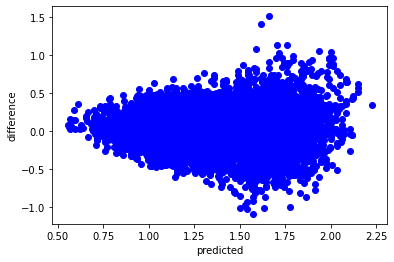

In [2251]:
plot_pred_vs_diff(preds_vs_act_cat);

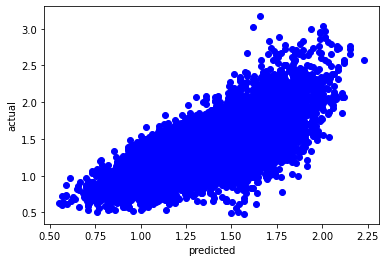

In [2252]:
plot_pred_vs_act(preds_vs_act_cat); #This looks compelling that we are predicting well...

In [2253]:
df_new.head(2)

,average_price,total_volume,small_size,medium_size,large_size,total_bags,small_bags,large_bags,xlarge_bags,type_organic,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,1,...,0,0,0,0,0,0,0,0,0,0


We are going to see if we can do even better. Let's create the X (explanatory matrix) and y (response vector) to be used in the model.

In [2254]:
def clean_data(df, response_col):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:

    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    4. Drop the unnecesary columns from X
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''

    y = df[response_col]
    
    #Drop columns
    df = df.drop([response_col], axis=1)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    df.shape
    return X, y
    
#Use the function to create X and y
X_av_price, y_av_price = clean_data(df_new, 'average_price')  

In [2255]:
df_new.head(2)
len(df_new.columns)

71

In [2256]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set       
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, y_test_preds
# print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_scores_train5, r2_scores_test5))

In [2257]:
X.head(2)

,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags
0,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0
1,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0


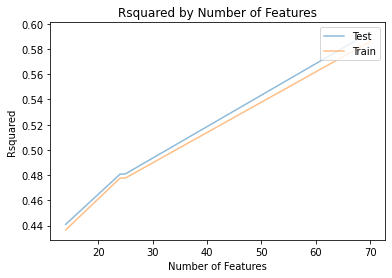

The rsquared on the training data was [0.43661998784325673, 0.43661998784325673, 0.4776497121180935, 0.477733998508038, 0.5858287899889043, 0.5858287899889043, 0.5858287899889043, 0.5858287899889043].  The rsquared on the test data was [0.4410229554094087, 0.4410229554094087, 0.4807850732084179, 0.48103283168545274, 0.5932431365415642, 0.5932431365415642, 0.5932431365415642, 0.5932431365415642].


In [2258]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model_opt, X_train_opt, X_test_opt, y_train_opt, y_test_opt, y_test_preds_opt = find_optimal_lm_mod(X_av_price, y_av_price, cutoffs)
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_scores_train, r2_scores_test))

In [2259]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_opt, y_test_preds_opt)))

The mean squared error in the test data was 0.05895750535325869


In [2260]:
preds_vs_act_opt = preds_vs_act(y_test_opt, y_test_preds_opt)
preds_vs_act_opt.head()

,actual,preds,diff
0,1.32,1.375019,-0.055019
1,1.51,1.577811,-0.067811
2,1.69,1.734098,-0.044098
3,1.67,1.506774,0.163226
4,2.17,1.520320,0.649680


R-Squared, also known as the Coefficient of Determination, is a value between 0 and 1 that measures how well our regression line fits our data. R-Squared can be interpreted as the percent of variance in our dependent variable that can be explained by our model. The closer R-Squared is to 1 or 100% the better our model will be at predicting our dependent variable.

Since we are using a rich regression model one of the best way to tell which x features matter in our model is to look at the weight of their coefficients. A larger coefficient means a larger influence or impact in the variable we are interested in, in this case average price. we can look at the size of the coefficients in the model as an indication of the impact of each variable on the average price. The larger the coefficient, the larger the expected impact on average price.

In [2261]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model_opt.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model_opt.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [2262]:
len(lm_model_opt.coef_)

70

In [2263]:
len(X_train_opt)

23433

In [2264]:
len(X_train_opt.columns)

70

In [2265]:
#Use the function
coef_df = coef_weights(lm_model_opt.coef_, X_train_opt)
coef_df.head(10)

,est_int,coefs,abs_coefs
8,type_organic,0.460003,0.460003
52,geography_SanFrancisco,0.348423,0.348423
30,geography_Houston,-0.323420,0.323420
24,geography_Dallas_FtWorth,-0.317197,0.317197
40,geography_NewYork,0.227027,0.227027
69,month_9,0.197715,0.197715
38,geography_Nashville,-0.191835,0.191835
14,year_2021,-0.190836,0.190836
68,month_8,0.188885,0.188885
23,geography_Columbus,-0.184116,0.184116


The analysis above of the coefficients is again consistent with our results we obtain before from our descriptive analysis. We did say that San Francisco, the month of September and type organic had the highest prices and Houston had the lowest average prices accordint to the analyzed information of our dataframe.

In [2266]:
def coef_weights(coefficients, X_train, lm_model):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    print(len(coefs_df))
    coefs_df['est_int'] = X_train.columns
#     print(len(X_train.columns))
#     print(len(lm_model.coef_))
    coefs_df['coefs'] = lm_model.coef_
    
    
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model_opt.coef_, X_train_opt, lm_model_opt)

#A quick look at the top results
coef_df.head(10)

0


,est_int,coefs,abs_coefs
8,type_organic,0.460003,0.460003
52,geography_SanFrancisco,0.348423,0.348423
30,geography_Houston,-0.323420,0.323420
24,geography_Dallas_FtWorth,-0.317197,0.317197
40,geography_NewYork,0.227027,0.227027
69,month_9,0.197715,0.197715
38,geography_Nashville,-0.191835,0.191835
14,year_2021,-0.190836,0.190836
68,month_8,0.188885,0.188885
23,geography_Columbus,-0.184116,0.184116


In [2267]:
lm_model_opt.intercept_

1.0856742437607163

In [2268]:
lm_model.intercept_

1.3933597664820982

One of the best out of the box methods for supervised machine learning is known as the RandomForest - let's see if we can use this model to outperform The linear model from earlier. Let's see what be the best number of features to use based on the test set performance

In [2269]:
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
         #fit the model and obtain pred response

        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
    
    #fit the model
    rf_model = RandomForestRegressor() 
    rf_model.fit(X_train, y_train)
    y_test_preds = rf_model.predict(X_test)
        
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test, y_test_preds

In [2270]:
#Use the function to create X and y
X_av_price_rf, y_av_price_rf = clean_data(df_new, 'average_price')  

In [2271]:
df_new.head(2)
X.head(2)

,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags
0,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0
1,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0


In [2272]:
df_new.shape

(33477, 71)

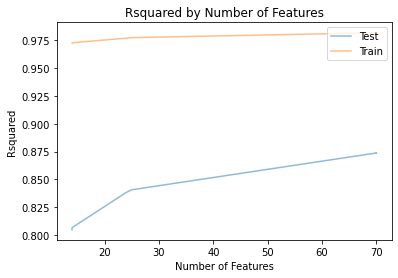

The rsquared on the training data was [0.9726974496913033, 0.9728047468355114, 0.976961884767719, 0.9774164842539115, 0.9817753635504679, 0.9818389803642226, 0.9819494041160874, 0.9818379314161351, 0.9822561369348239, 0.9818649395941896].  The rsquared on the test data was [0.8046292808440565, 0.806656658806556, 0.8383909936830432, 0.8407051744183964, 0.8737744443536817, 0.8737567876387671, 0.8737672227316674, 0.8737642271707148, 0.873657138650292, 0.8736566783152144].


In [2274]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 40, 30,20,2]
# r2_scores_test, r2_scores_train, rf_model, X_train, X_test,  y_train,     y_test
r2_test_rf, r2_train_rf, rf_model_rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, y_test_preds_rf = find_optimal_rf_mod(X_av_price_rf, y_av_price_rf, cutoffs)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_train_rf, r2_test_rf))

In [ ]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_rf, y_test_preds_rf)))

We can see that RandomForest did helped us to improve our model. The rsquared values we were able to get before were 0.61 and 0.62 in train and test data respectively. Now we have values of 0.98 for training and 0.88 for test data.

In [2275]:
preds_vs_act_rf = preds_vs_act(y_test_rf, y_test_preds_rf)
preds_vs_act_rf.head()

,actual,preds,diff
0,1.32,1.3347,-0.0147
1,1.51,1.5106,-0.0006
2,1.69,1.7906,-0.1006
3,1.67,1.6407,0.0293
4,2.17,2.0605,0.1095


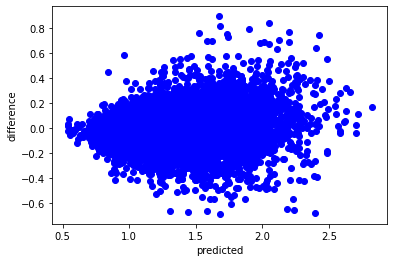

In [2276]:
plot_pred_vs_diff(preds_vs_act_rf);

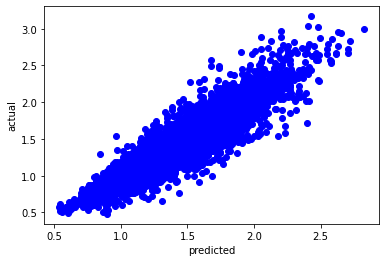

In [2277]:
plot_pred_vs_act(preds_vs_act_rf);

In [1077]:
### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod_grid_search(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
        
        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
            
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])
    
     #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
    rf_model.fit(X_train, y_train)
     
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurren

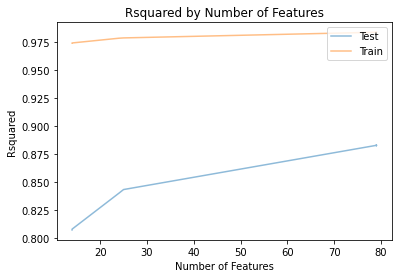

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min


The rsquared on the training data was [0.9738767040448858, 0.9739886601699532, 0.9782145181296853, 0.9784894968722304, 0.9835356758954406, 0.9835377343240121, 0.9835363406545642, 0.9835250889756829, 0.9834993383918476, 0.9835152592684687].  The rsquared on the test data was [0.8075331081101369, 0.808193870074664, 0.8402068643104824, 0.8434753904364829, 0.8828501729916738, 0.8830283382392703, 0.882751777290296, 0.8825083862561715, 0.8827683018187219, 0.8827979104545558].


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


In [1078]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
params = {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10, 100]}
r2_test_rf_gs, r2_train_rf_gs, rf_model_rf_gs, X_train_rf_gs, X_test_rf_gs, y_train_rf_gs, y_test_rf_gs = find_optimal_rf_mod_grid_search(X_av_price_rf, y_av_price_rf, cutoffs, param_grid=params)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_train_rf_gs, r2_test_rf_gs))

To run the model with GridSearch took a long time and we can see that the improvement was minimal.

In [385]:
# it would be interesting to do the same analysis but predicting total volume sold instead of average prices
# relationship with total ammount and location- what are the locations that sell more avocadoes
# of the locations that sell more avocado, what are the average prices of this location and
# what is the difference in percentage of price with those that sale the least. Here we will 
# look at the total-volume.

Next we will create a new model to predict volumen and see what insights we can get to answer our questions. We are interested to get more information about the regions and their total volume. This is important because the greater the supply the lower the prices will generally be. This information is relevant to producers that will want to price their product to a competitive ammount and be compeating failry in the market. To know the trend of the total volume sold and its future predictions can also help producers to make decisions about expenses and possible loses.

In [2278]:
# df1 = pd.read_csv('./avocado-updated-2020.csv')
# df1.head()
df1 = df.copy(deep=True)

In [2279]:
df1.head(2)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1
1,2015-01-04,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,organic,2015,Albany,1


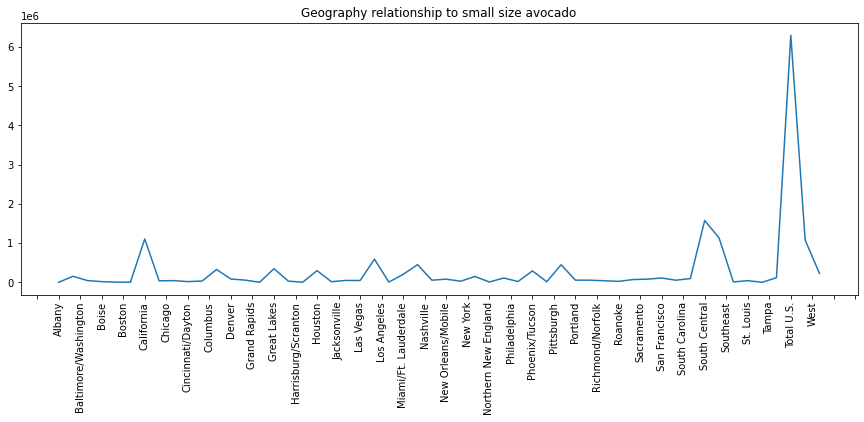

In [2280]:
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(51))
plt.title("Geography relationship to small size avocado")
plt.plot(df1.groupby(['geography']).mean()['4046']);
plt.xticks(rotation = 90);
# df1.groupby(['geography']).mean()['4770'].sort_values()

Below we analyze the linear model with total_volume as the response column or our dependent variable.

In [2281]:
#Split into explanatory and response variables
X_v = df[['average_price', '4046', '4225','4770','total_bags','small_bags','large_bags','xlarge_bags']]
y_v = df['total_volume']

#Split into train and test
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, test_size = .30, random_state=42) 

lm_model_v = LinearRegression(normalize=True) # Instantiate
lm_model_v.fit(X_train_v, y_train_v) #Fit
        
#Predict and score the model
y_test_preds_v = lm_model_v.predict(X_test_v) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test_v, y_test_preds_v), len(y_test_v))

'The r-squared score for the model using only quantitative variables was 0.9981755840465437 on 10044 values.'

In [2282]:
lm_model_v.coef_

array([-5.49209777e+03,  1.02504002e+00,  9.56624408e-01,  1.26396766e+00,
        1.69396760e+03, -1.69290656e+03, -1.69307189e+03, -1.69305466e+03])

In [2283]:
lm_model_v.score(X_test_v, y_test_v)

0.9981755840465437

In [2284]:
# # geography -> Let's look at San Diego
# lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Boston', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
#        'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
#        'geography_GrandRapids', 'geography_GreatLakes',
#        'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
#        'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
#        'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
#        'geography_Miami_FtLauderdale', 'geography_Midsouth',
#        'geography_Nashville', 'geography_NewOrleans_Mobile',
#        'geography_NewYork', 'geography_Northeast',
#        'geography_NorthernNewEngland', 'geography_Orlando', 'geography_Phoenix_Tucson',
#        'geography_Pittsburgh', 'geography_Plains', 'geography_Portland',
#        'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
#        'geography_Roanoke', 'geography_Sacramento','geography_SanFrancisco', 'geography_Seattle',
#        'geography_SouthCarolina', 'geography_SouthCentral',
#        'geography_Southeast', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_TotalUS',
#        'geography_West', 'geography_WestTex_NewMexico']])
# result = lm.fit()
# result.summary()

In [2285]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_v, y_test_preds_v)))

The mean squared error in the test data was 28923529939.585175


Despite the R-squared value was almost one, the MSE seems we got is too high. We will try to see if we can improve this.

In [2286]:
preds_vs_act_v = preds_vs_act(y_test_v, y_test_preds_v)
preds_vs_act_v.head()

,actual,preds,diff
0,7650.63,9029.424004,-1378.794004
1,9599.33,10140.614070,-541.284070
2,1708.12,820.788711,887.331289
3,11214.42,11089.504463,124.915537
4,14770.00,11376.378764,3393.621236


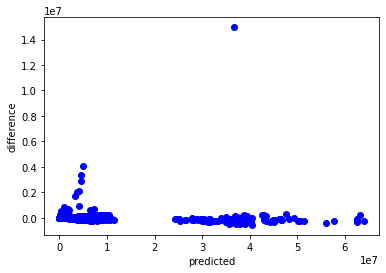

In [2287]:
plot_pred_vs_diff(preds_vs_act_v);

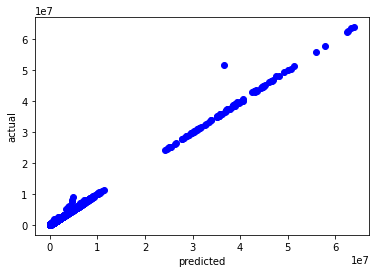

In [2288]:
plot_pred_vs_act(preds_vs_act_v);

We are able to see some outliers. An outlier is an observation that lies an abnormal distance from other values in a random sample from our population. In our case we can predict that these data points might create an issue for our model and its predictions. We will attempt to remove these.

In [2289]:
# make a copy of the matrix
no_out_df = df_new.copy(deep=True)
no_out_df.head(2)

,average_price,total_volume,small_size,medium_size,large_size,total_bags,small_bags,large_bags,xlarge_bags,type_organic,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,1.22,40873.28,2819.50,28287.42,49.9,9716.46,9186.93,529.53,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.79,1373.95,57.42,153.88,0.0,1162.65,1162.65,0.00,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [2290]:
no_out_df.shape

(33477, 71)

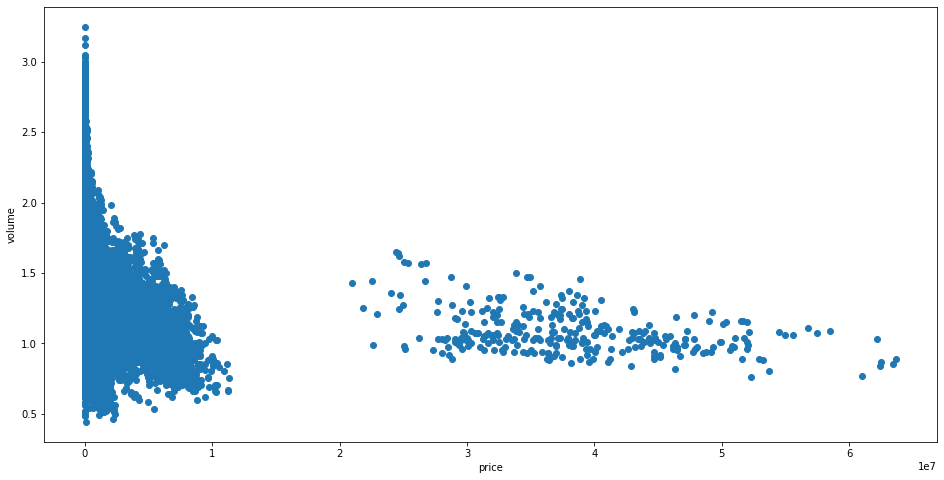

In [2291]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(no_out_df['total_volume'], no_out_df['average_price'])
ax.set_xlabel('price')
ax.set_ylabel('volume')
plt.show()

In [2292]:
# set the variable y to the y-axis, remove the numbers in the first and last quantile.
y = no_out_df['total_volume']
removed_outliers = y.between(y.quantile(.25), y.quantile(.75))
print(str(y[removed_outliers].size) +  " data points remain.") 

16739 data points remain.


In [2293]:
# y[removed_outliers].plot().get_figure()

In [2294]:
removed_outliers.value_counts()

True     16739
False    16738
Name: total_volume, dtype: int64

In [2295]:
df_new.shape

(33477, 71)

In [2296]:
no_out_df.shape

(33477, 71)

In [2297]:
removed_outliers.head()

0     True
1    False
2     True
3    False
4    False
Name: total_volume, dtype: bool

In [2298]:
index_names = no_out_df[~removed_outliers].index # INVERT removed_outliers!!
index_names # The result to drop.

Int64Index([    1,     3,     4,     7,     9,    11,    12,    15,    16,
               19,
            ...
            33459, 33461, 33464, 33466, 33468, 33469, 33471, 33472, 33473,
            33475],
           dtype='int64', length=16738)

In [2299]:
no_out_df.drop(index_names, inplace=True)

In [2300]:
no_out_df.shape

(16739, 71)

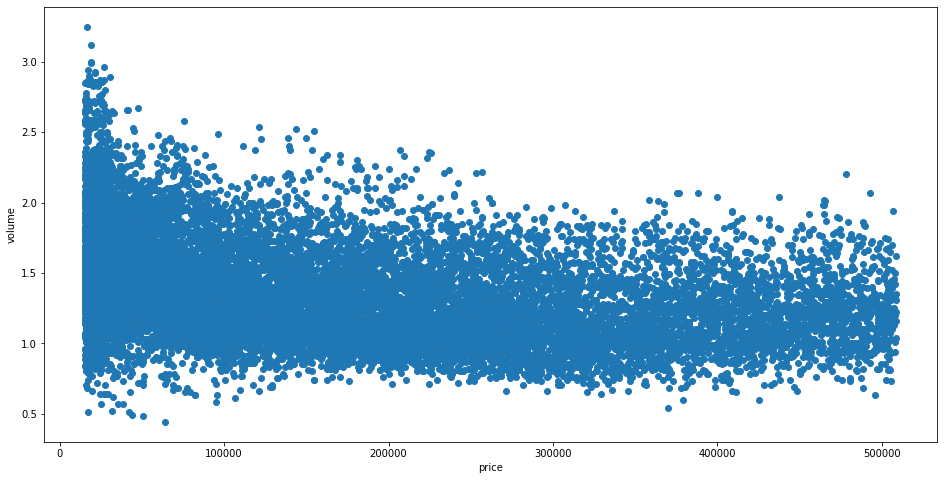

In [2301]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(no_out_df['total_volume'], no_out_df['average_price'])
ax.set_xlabel('price')
ax.set_ylabel('volume')
plt.show()

Lets try our lineal model with total_volume as a response column to see how we did.

In [2302]:
#Test your function with the above dataset
test_score_tv, train_score_tv, lm_model_tv, X_train_tv, X_test_tv, y_train_tv, y_test_tv, y_test_preds_tv = clean_fit_linear_mod(no_out_df, 'total_volume', cat_cols_lst, dummy_na=False)
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(test_score_tv, test_score_tv))

The rsquared on the training data was 0.9970986940233001.  The rsquared on the test data was 0.9970986940233001.


In [2303]:
math.sqrt(mean_squared_error(y_test_tv, y_test_preds_tv))

7370.356656396772

In [2304]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_tv, y_test_preds_tv)))
print("The mean squared error in the train data was {}".format(mean_squared_error(y_train_tv, lm_model_tv.predict(X_train_tv))))

The mean squared error in the test data was 54322157.242492214
The mean squared error in the train data was 52344073.281255595


MSE still is too high...

In [2305]:
preds_vs_act_tv = preds_vs_act(y_test_tv, y_test_preds_tv)
preds_vs_act_tv.head()

,actual,preds,diff
0,328687.51,329363.214582,-675.704582
1,93663.48,93785.184785,-121.704785
2,308828.87,308483.096407,345.773593
3,62870.49,63040.745929,-170.255929
4,371578.11,372219.071284,-640.961284


In [2306]:
preds_vs_act_tv = preds_vs_act(y_test_tv, y_test_preds_tv)
preds_vs_act_tv.head()

,actual,preds,diff
0,328687.51,329363.214582,-675.704582
1,93663.48,93785.184785,-121.704785
2,308828.87,308483.096407,345.773593
3,62870.49,63040.745929,-170.255929
4,371578.11,372219.071284,-640.961284


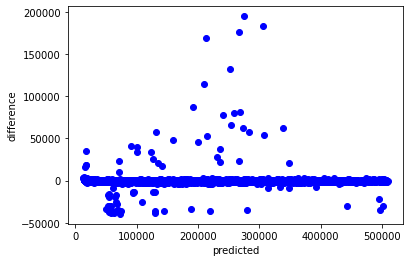

In [2307]:
plot_pred_vs_diff(preds_vs_act_tv);

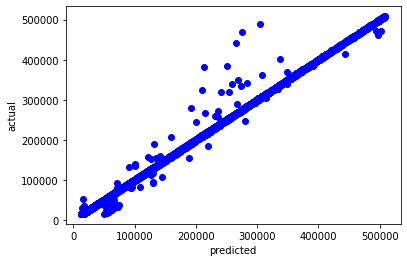

In [2308]:
plot_pred_vs_act(preds_vs_act_tv);

In [2309]:
# df_new.columns

In [2310]:
def clean_data_tv(df, response_col):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:

    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    4. Drop the unnecesary columns from X
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''

    y = df[response_col]
    
    #Drop columns
    df = df.drop([response_col], axis=1)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    df.shape
    return X, y

In [2311]:
# # lets get x and y to try the response column with our find_optimal_lm_model 
X_tv_op, y_tv_op= clean_data_tv(no_out_df, 'total_volume') 

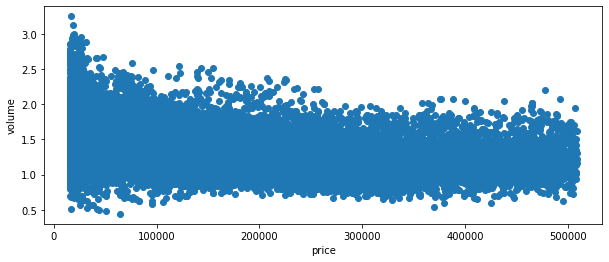

In [2312]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(no_out_df['total_volume'], no_out_df['average_price'])
ax.set_xlabel('price')
ax.set_ylabel('volume')
plt.show()

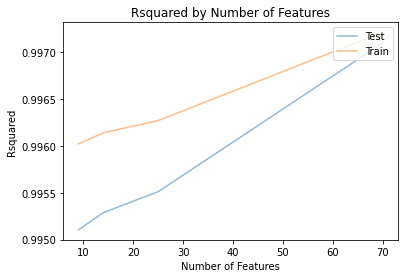

The rsquared on the training data was [0.9951025742070724, 0.9951025742070724, 0.9952869361047656, 0.9955111891254185, 0.9970986940233001, 0.9970986940233001, 0.9970986940233001, 0.9970986940233001, 0.9970986940233001, 0.9970986940233001].  The rsquared on the test data was [0.9960210976476207, 0.9960210976476207, 0.9961386582812927, 0.9962696677530155, 0.9972122891133248, 0.9972122891133248, 0.9972122891133248, 0.9972122891133248, 0.9972122891133248, 0.9972122891133248].


In [2313]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25,10,2]

r2_scores_test_tv_op, r2_scores_train_tv_op, lm_model_tv_op, X_train_tv_op, X_test_tv_op, y_train_tv_op, y_test_tv_op, y_test_preds_tv_op= find_optimal_lm_mod(X_tv_op, y_tv_op, cutoffs)
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_scores_test_tv_op, r2_scores_train_tv_op))

In [2068]:
math.sqrt(mean_squared_error(y_test_tv_op, y_test_preds_tv_op))

7370.356656396772

In [2314]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_tv_op, y_test_preds_tv_op)))
print("The mean squared error in the train data was {}".format(mean_squared_error(y_train_tv_op, lm_model_tv_op.predict(X_train_tv_op))))

The mean squared error in the test data was 54322157.242492214
The mean squared error in the train data was 52344073.281255595


In [2074]:
preds_vs_act_tv_op = preds_vs_act(y_test_tv_op, y_test_preds_tv_op)
preds_vs_act_tv_op.head()

,actual,preds,diff
0,328687.51,329363.214582,-675.704582
1,93663.48,93785.184785,-121.704785
2,308828.87,308483.096407,345.773593
3,62870.49,63040.745929,-170.255929
4,371578.11,372219.071284,-640.961284


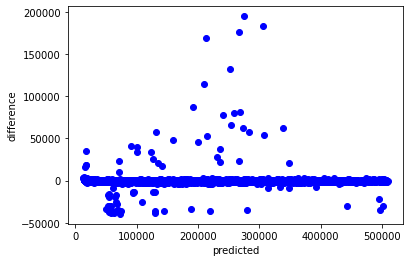

In [2075]:
plot_pred_vs_diff(preds_vs_act_tv_op);

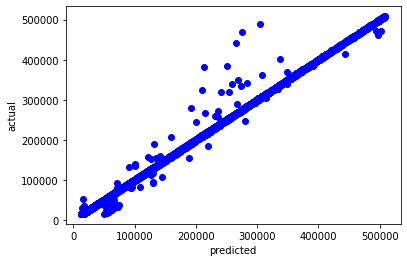

In [2076]:
plot_pred_vs_act(preds_vs_act_tv_op);

explanation possible
https://www.investopedia.com/terms/r/r-squared.asp

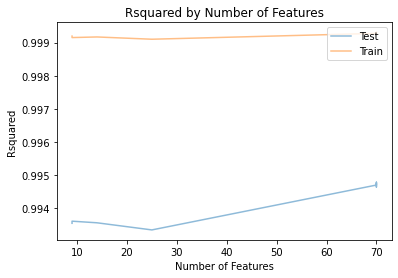

The rsquared on the training data was [0.972880852356116, 0.9725548092485496, 0.9769908685499706, 0.9774785186794415, 0.981856213035165, 0.9818125485944811, 0.9817947667990645, 0.9817730350516677, 0.9819648631142045, 0.9817612922231652].  The rsquared on the test data was [0.8050155890516184, 0.8055123686451704, 0.8387072686232652, 0.8400630135105767, 0.873461776178667, 0.8737151443938352, 0.8730941902287763, 0.8744596253422257, 0.8739491301029177, 0.8729261820548277].


In [2077]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 40, 30,20,2]
# r2_scores_test, r2_scores_train, rf_model, X_train, X_test,  y_train,     y_test
r2_test_rf_tv, r2_train_rf_tv, rf_model_rf_tv, X_train_rf_tv, X_test_rf_tv, y_train_rf_tv, y_test_rf_tv, y_test_preds_rf_tv = find_optimal_rf_mod(X_tv_op, y_tv_op, cutoffs)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_train_rf, r2_test_rf))

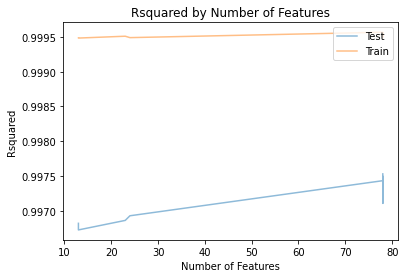

The rsquared on the training data was [0.972880852356116, 0.9725548092485496, 0.9769908685499706, 0.9774785186794415, 0.9826038546705761, 0.9825498066421103, 0.9826352094851202, 0.9825034798239418, 0.9826888357007919, 0.9825560463316184].  The rsquared on the test data was [0.8050155890516184, 0.8055123686451704, 0.8387072686232652, 0.8400630135105767, 0.8805290813762481, 0.8812382505158767, 0.8811466048679875, 0.881229403231083, 0.8804519604172898, 0.8807315183511458].


In [748]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 40, 30,20,2]
# r2_scores_test, r2_scores_train, rf_model, X_train, X_test,  y_train,     y_test
r2_test_rf_tv, r2_train_rf_tv, rf_model_rf_tv, X_train_rf_tv, X_test_rf_tv, y_train_rf_tv, y_test_rf_tv, y_test_preds_rf_tv = find_optimal_rf_mod(X_tv_op, y_tv_op, cutoffs)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_train_rf, r2_test_rf))

In [2083]:
#fit the model
rf_model = RandomForestRegressor() 
rf_model.fit(X_train_rf_tv, y_train_rf_tv)
y_test_preds_tv_rf = rf_model.predict(X_test_rf_tv)

In [2084]:
preds_vs_act_tv_rf = preds_vs_act(y_test_rf_tv, y_test_preds_rf_tv)
preds_vs_act_tv_rf.head()

,actual,preds,diff
0,328687.51,331688.5472,-3001.0372
1,93663.48,93043.7505,619.7295
2,308828.87,304012.7907,4816.0793
3,62870.49,69826.6853,-6956.1953
4,371578.11,393400.1945,-21822.0845


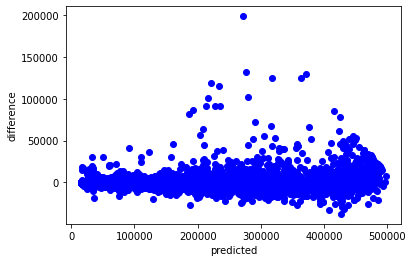

In [2085]:
plot_pred_vs_diff(preds_vs_act_tv_rf);

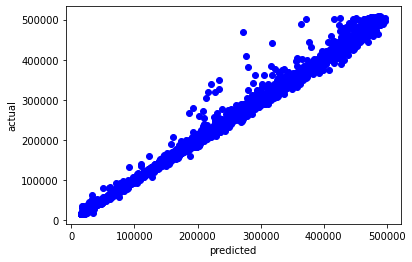

In [2086]:
plot_pred_vs_act(preds_vs_act_tv_rf);

In [2087]:
print("The mean squared error in the test data was {}".format(mean_squared_error(y_test_rf_tv, y_test_preds_rf_tv)))
print("The mean squared error in the train data was {}".format(mean_squared_error(y_train_rf_tv, rf_model_rf_tv.predict(X_train_rf_tv))))

The mean squared error in the test data was 100082758.54663698
The mean squared error in the train data was 13043233.13650619


We decided that the models made to predict total volume will need more work. We are not satisfied with the high MSE and even though after a few attempts we were able to bring it down, we decided that it will need more work.

In [575]:
# in the part below i am attempting to do more analysis going through the 
# material to see what other important information we could use for this project.

In [2088]:
df['type'].value_counts()
type(df['type'])
df['year'].value_counts()

2017    5722
2016    5616
2019    5616
2015    5615
2018    5292
2020    5184
2021     432
Name: year, dtype: int64

In [2089]:
# Proportion of avocados that are conventional
prop_type = df['type'].value_counts(normalize=True).mul(100)
len(df[df['type'] == 'conventional'])/df.shape[0]
prop_type[0]/100

0.5000448068823371

In [2090]:
# Proportion of avocados that are organic
len(df[df['type'] == 'organic'])/df.shape[0]
prop_type[1]/100

0.4999551931176629

In [2091]:
# What proportion of conventional avocadoes where sold in year 2015?
df.query('type == "conventional" and year == "2015"').count()[0]/len(df[df['type'] == 'conventional'])

0.16774193548387098

In [607]:
x = str(2015)
type(df['year'][0])

str

In [2092]:
df.query('type == "conventional" and year == "2016"').count()[0]/len(df[df['type'] == 'conventional'])

0.16774193548387098

In [2093]:
df.query('type == "conventional" and year == "2017"').count()[0]/len(df[df['type'] == 'conventional'])

0.17096774193548386

In [2094]:
df.query('type == "conventional" and year == "2018"').count()[0]/len(df[df['type'] == 'conventional'])

0.15806451612903225

In [2095]:
df.query('type == "conventional" and year == "2019"').count()[0]/len(df[df['type'] == 'conventional'])

0.16774193548387098

In [2096]:
df[df['type'] == 'conventional']['year'].count()

16740

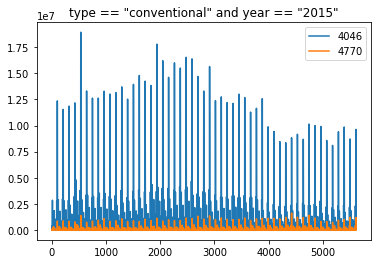

In [2098]:
q = 'type == "conventional" and year == "2015"'
df.query(q)[['4046','4770']].plot(title=q);

In simple linear regression, we compare two quantitative variables to one another. In the next analysis we are going to use linear ordinary least squares (OLS) model.

The response variable is what you want to predict, while the explanatory variable is the variable you use to predict the response.

In [2123]:
df.head(1)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month
0,2015-01-04,1.22,40873.28,2819.5,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1


In [2315]:
# if we tried to predict price
df['intercept'] = 1
lm = sm.OLS(df['average_price'], df[['intercept', 'total_volume']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1184.
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          4.36e-255
Time:                        14:25:29   Log-Likelihood:                -14461.
No. Observations:               33477   AIC:                         2.893e+04
Df Residuals:                   33475   BIC:                         2.894e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.3936      0.002    664.312      0.000       1.390       1.398
total_volume -1.772e-08   5.15e-10    -34.414      0.000   -1.87e-08   -1.67e-08
==============================================================================
Omnibus:                     1885.102   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2238.172
Skew:                           0.598   Prob(JB):                         0.00
Kurtosis:                       3.415   Cond. No.                     4.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For every unit increase of total volume sales we would predict that the proce will decrease by 1.77 USD.

Total_volume is statistically signifficant and the results suggest that as the independent variable increases (total_volume), the dependent variable tends to decrease (average_price). For every unit increase of total volume sales we would predict that the proce will decrease by 1.77 USD.

In [2316]:
# if we try to predict volume
lm = sm.OLS(df['total_volume'], df[['intercept', 'average_price']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_volume   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1184.
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          4.36e-255
Time:                        14:25:32   Log-Likelihood:            -5.5545e+05
No. Observations:               33477   AIC:                         1.111e+06
Df Residuals:                   33475   BIC:                         1.111e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      3.627e+06      8e+04     45.349      0.000    3.47e+06    3.78e+06
average_price -1.928e+06    5.6e+04    -34.414      0.000   -2.04e+06   -1.82e+06
==============================================================================
Omnibus:                    49196.969   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13618965.408
Skew:                           9.219   Prob(JB):                         0.00
Kurtosis:                     100.075   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the average price increases, total_volume decreases.

From a simple analysis above we can see that out r-squared value is not that great. Yet, we are able to see that total_volume is statistically significnat for predicting price.

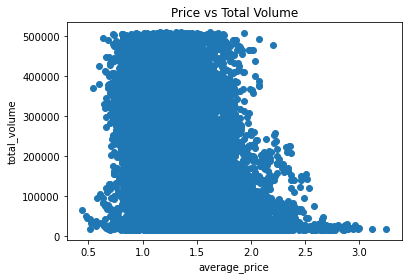

In [2317]:
plt.scatter(no_out_df['average_price'], no_out_df['total_volume']);
plt.xlabel('average_price');
plt.ylabel('total_volume');
plt.title('Price vs Total Volume');

In [2318]:
# correlation coefficient
math.sqrt(0.167)

0.408656334834051

Simple linear regression didnt help us too much. We are going to use now multiple linear regression since we have more variables including categoricals that we can check. We will be using both quantitative and categorical x-variables to predict a quantitative response.

In [2319]:
# # geography -> Let's look at San Diego
# lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Boston', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
#        'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
#        'geography_GrandRapids', 'geography_GreatLakes',
#        'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
#        'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
#        'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
#        'geography_Miami_FtLauderdale', 'geography_Midsouth',
#        'geography_Nashville', 'geography_NewOrleans_Mobile',
#        'geography_NewYork', 'geography_Northeast',
#        'geography_NorthernNewEngland', 'geography_Orlando', 'geography_Phoenix_Tucson',
#        'geography_Pittsburgh', 'geography_Plains', 'geography_Portland',
#        'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
#        'geography_Roanoke', 'geography_Sacramento','geography_SanFrancisco', 'geography_Seattle',
#        'geography_SouthCarolina', 'geography_SouthCentral',
#        'geography_Southeast', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_TotalUS',
#        'geography_West', 'geography_WestTex_NewMexico']])
# result = lm.fit()
# result.summary()

Let's say that we ae interested in avocado businees and we will like to know what is the average price we should charge for the units. If we are going to sale avocados in California State, we can look at the prices we would be able to charge by specifying the city.

To answer this question we will look at the data that we already have. We know that the size of the avocados as well as the locations where avocados are sold can dictate or influence prices.

We can attempt to do this using linear algebra to predict our price using all our variables at the same time (categorical and quantitative).

For this we need to create a matrix of inputs (X) and a vector of the response that we want to predict (y). But since we already built one before, we will be using it here as well.

Let's try to fit our lineal model using quantitative variables first.

In [2320]:
df.head(1)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,month,intercept
0,2015-01-04,1.22,40873.28,2819.5,28287.42,49.9,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,1


In [2321]:
df_new['intercept'] = 1
lm = sm.OLS(df_new['average_price'], df_new[['intercept', 'total_volume','small_size','medium_size','large_size','total_bags','small_bags','large_bags','xlarge_bags']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     216.1
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:26:02   Log-Likelihood:                -14200.
No. Observations:               33477   AIC:                         2.842e+04
Df Residuals:                   33468   BIC:                         2.849e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.3920      0.002    667.234      0.000       1.388       1.396
total_volume -2.094e-08   1.08e-08     -1.931      0.053   -4.22e-08     3.1e-10
small_size   -8.938e-08   1.23e-08     -7.278      0.000   -1.13e-07   -6.53e-08
medium_size   8.934e-08   1.17e-08      7.630      0.000    6.64e-08    1.12e-07
large_size   -3.165e-07   4.64e-08     -6.817      0.000   -4.08e-07   -2.26e-07
total_bags       0.0071      0.018      0.395      0.693      -0.028       0.042
small_bags      -0.0071      0.018     -0.395      0.693      -0.042       0.028
large_bags      -0.0071      0.018     -0.395      0.693      -0.042       0.028
xlarge_bags     -0.0071      0.018     -0.395      0.693      -0.042       0.028
==============================================================================
Omnibus:                     2176.493   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2648.728
Skew:                           0.649   Prob(JB):                         0.00
Kurtosis:                       3.461   Cond. No.                     8.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'total_bags','small_bags','large_bags','xlarge_bags' showed us to be statistically significant. We could say now that for each additional unit increase of avocados sold, average prices are expected to decrease by 2.09 as long as all the other variables stay the same. There is an issue with this statement though because p value asociated with total_volume is slightly greater than 0.05, this will make total_volume not statistically significant.

Since we are not getting a good r-squared value and we know that there are potential problems related to Multiple Linear Regression, we are wondering if our model is accurate. Next we are going to check for multicollinearity, which is one of the five potential problems.

Multicollinearity is when we have predictor variables that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from simple linear regression.

One of the most common ways to identify multicollinearity is with bivariate plots or with variance inflation factors (or VIFs). 

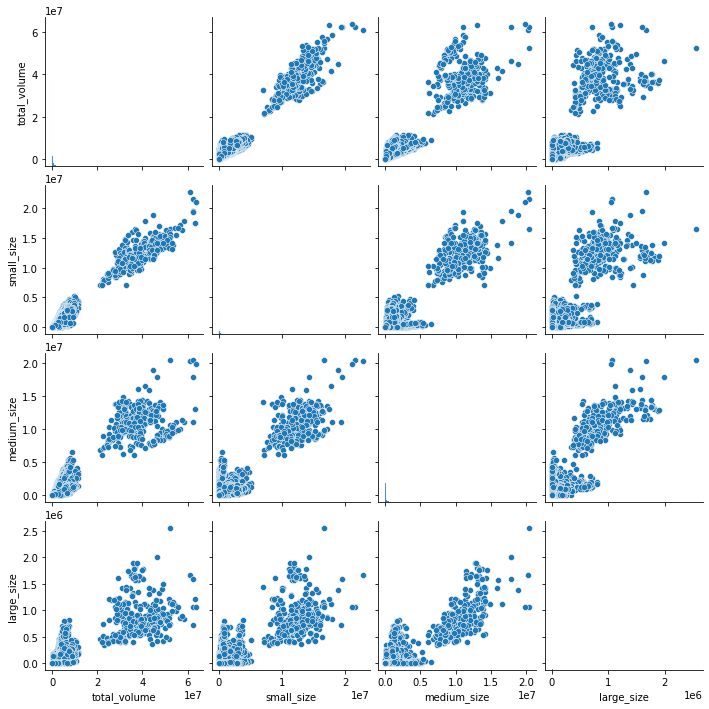

In [2133]:
sb.pairplot(df_new[['total_volume','small_size','medium_size','large_size']]);

In [2134]:
# sb.pairplot(no_out_df[['4046','4225','4770']]);

In [2342]:
df_new['intercept'] = 1
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'total_volume','small_size','medium_size','large_size', 'total_bags','small_bags','large_bags','xlarge_bags']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     755.1
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:06:18   Log-Likelihood:                -6492.2
No. Observations:               23433   AIC:                         1.300e+04
Df Residuals:                   23424   BIC:                         1.307e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5140      0.003    523.223      0.000       1.508       1.520
total_volume -1.215e-06   1.36e-07     -8.950      0.000   -1.48e-06   -9.49e-07
small_size   -1.328e-08   1.39e-07     -0.095      0.924   -2.86e-07     2.6e-07
medium_size   1.103e-06   1.37e-07      8.047      0.000    8.34e-07    1.37e-06
large_size   -6.154e-08   2.03e-07     -0.303      0.762    -4.6e-07    3.37e-07
total_bags       0.0041      0.018      0.232      0.817      -0.030       0.039
small_bags      -0.0041      0.018     -0.232      0.817      -0.039       0.030
large_bags      -0.0041      0.018     -0.232      0.817      -0.039       0.030
xlarge_bags     -0.0041      0.018     -0.232      0.817      -0.039       0.030
==============================================================================
Omnibus:                     1838.231   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2502.801
Skew:                           0.671   Prob(JB):                         0.00
Kurtosis:                       3.874   Cond. No.                     6.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that size small_size and large_size have negative coefficient. The interpretation of these coefficients now is counter intuitive to the relationship we expected from our pairplot results. This is one of the side effects to have milticollinearity in our model. Let's look at the other way to identify if our predictor is correlated to one another using variance inflation factor (VIF)

In [2323]:
y, X = dmatrices('average_price ~ total_volume + small_size + medium_size + large_size + small_bags + large_bags + xlarge_bags', df_new_names, return_type='dataframe')

vif =pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF Factor,features
0,1.924717,Intercept
1,241.314654,total_volume
2,35.370988,small_size
3,56.671581,medium_size
4,2.428710,large_size
5,23.175470,small_bags
6,11.336250,large_bags
7,1.320103,xlarge_bags


Let's remove total_volume and other variables since the vif factor is too high. We will also remove bags since they dont seem to be statistically significant.

In [2324]:
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept','small_size','medium_size','large_size', 'total_bags','large_bags']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     1188.
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:26:31   Log-Likelihood:                -6532.2
No. Observations:               23433   AIC:                         1.308e+04
Df Residuals:                   23427   BIC:                         1.312e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.5132      0.003    522.625      0.000       1.508       1.519
small_size  -1.235e-06   2.78e-08    -44.452      0.000   -1.29e-06   -1.18e-06
medium_size -1.101e-07   2.07e-08     -5.325      0.000   -1.51e-07   -6.96e-08
large_size  -1.284e-06   1.43e-07     -8.995      0.000   -1.56e-06      -1e-06
total_bags  -7.609e-07   3.61e-08    -21.061      0.000   -8.32e-07    -6.9e-07
large_bags   5.359e-07    6.8e-08      7.881      0.000    4.03e-07    6.69e-07
==============================================================================
Omnibus:                     1817.321   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2469.698
Skew:                           0.666   Prob(JB):                         0.00
Kurtosis:                       3.870   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We do see that r-quared value increased.

In [2325]:
y, X = dmatrices('average_price ~ small_size + medium_size + large_size +total_bags + large_bags', df_new_names, return_type='dataframe')

vif =pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF Factor,features
0,1.920818,Intercept
1,1.402737,small_size
2,1.285304,medium_size
3,1.195323,large_size
4,3.171366,total_bags
5,2.541204,large_bags


Our VIF Factors now are below 10. All the variables in this model showed us to be statistically significant. We could say now that for each additional small size avocado sold, medium size and large size avocado average prices are expected to decrease by 1.24, 1.10 and 1.28 respectively as long as all the other variables stay the same. 

We are also insterested to look at the relationship of total_volume and prices

In [2326]:
lm = sm.OLS(df_new['total_volume'], df_new[['intercept', 'average_price','small_size','medium_size','large_size']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_volume   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 4.063e+04
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:27:07   Log-Likelihood:            -2.9915e+05
No. Observations:               23433   AIC:                         5.983e+05
Df Residuals:                   23428   BIC:                         5.984e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.043e+05   2639.208     39.535      0.000    9.92e+04     1.1e+05
average_price  -4.04e+04   1710.912    -23.615      0.000   -4.38e+04    -3.7e+04
small_size        1.4949      0.007    215.709      0.000       1.481       1.508
medium_size       1.1844      0.005    222.932      0.000       1.174       1.195
large_size        1.1272      0.038     29.957      0.000       1.053       1.201
==============================================================================
Omnibus:                    10099.416   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63987.258
Skew:                           1.973   Prob(JB):                         0.00
Kurtosis:                      10.069   Cond. No.                     8.30e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the association of total_volume of avocados sold and average_price in our dataset, we get R-squared value of 0.874, It means that the variability in total_volume can explain 87.4% of the variability in average_price.

'average_price','small_size','medium_size','large_size' showed us to be statistically significant, meaning that they are statiscally related to the response. We could say now that as average_price increases, total_volume is expected to decrease by 4.04e+04 as long as all the other variables stay the same. 

On both of the models we get warnings that point out a flaw in the model: there could be strong multicollinearity - which means the explanatory variables used could be correlated. This can lead to some instability in the parameter estimation, but it is difficult to predict the exact effects of multicollinearity. In this case, both variables are still significantly associated with our dependent variable and the coefficients are places in small confidence intervals. 

Next we are going to use our categorical variables in our lineal model.

In [2329]:
df_new.columns

Index(['average_price', 'total_volume', 'small_size', 'medium_size',
       'large_size', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type_organic', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'geography_Atlanta',
       'geography_Baltimore_Washington', 'geography_Boise', 'geography_Boston',
       'geography_Buffalo_Rochester', 'geography_Charlotte',
       'geography_Chicago', 'geography_Cincinnati_Dayton',
       'geography_Columbus', 'geography_Dallas_FtWorth', 'geography_Denver',
       'geography_Detroit', 'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Houston',
       'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast', 

In [2330]:
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'type_organic', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'geography_Atlanta',
       'geography_Baltimore_Washington', 'geography_Boise', 'geography_Boston',
       'geography_Buffalo_Rochester', 'geography_Charlotte',
       'geography_Chicago', 'geography_Cincinnati_Dayton',
       'geography_Columbus', 'geography_Dallas_FtWorth', 'geography_Denver',
       'geography_Detroit', 'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Houston',
       'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast', 'geography_Orlando',
       'geography_Philadelphia', 'geography_Phoenix_Tucson',
       'geography_Pittsburgh', 'geography_Portland',
       'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento', 'geography_SanDiego',
       'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_Spokane', 'geography_StLouis',
       'geography_Syracuse', 'geography_Tampa', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     500.4
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:31:08   Log-Likelihood:                 718.18
No. Observations:               23433   AIC:                            -1310.
Df Residuals:                   23370   BIC:                            -802.5
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.0877      0.008    141.642      0.000       1.073       1.103
type_organic                       0.3788      0.004    107.489      0.000       0.372       0.386
year_2016                          0.0037      0.006      0.654      0.513      -0.007       0.015
year_2017                          0.1965      0.006     35.546      0.000       0.186       0.207
year_2018                          0.0440      0.006      7.903      0.000       0.033       0.055
year_2019                          0.0987      0.006     17.903      0.000       0.088       0.110
year_2020                         -0.0277      0.006     -4.910      0.000      -0.039      -0.017
year_2021                         -0.1042      0.015     -7.126      0.000      -0.133      -0.076
geography_Atlanta                 -0.1641      0.011    -15.036      0.000      -0.186      -0.143
geography_Baltimore_Washington     0.0474      0.011      4.339      0.000       0.026       0.069
geography_Boise                   -0.0908      0.014     -6.436      0.000      -0.118      -0.063
geography_Boston                   0.0985      0.011      9.135      0.000       0.077       0.120
geography_Buffalo_Rochester       -0.0715      0.012     -6.093      0.000      -0.094      -0.048
geography_Charlotte                0.0693      0.011      6.234      0.000       0.047       0.091
geography_Chicago                  0.1101      0.011     10.426      0.000       0.089       0.131
geography_Cincinnati_Dayton       -0.2005      0.010    -19.199      0.000      -0.221      -0.180
geography_Columbus                -0.2494      0.011    -21.927      0.000      -0.272      -0.227
geography_Dallas_FtWorth          -0.2935      0.014    -21.488      0.000      -0.320      -0.267
geography_Denver                  -0.1607      0.011    -14.461      0.000      -0.182      -0.139
geography_Detroit                 -0.1992      0.011    -18.860      0.000      -0.220      -0.178
geography_GrandRapids             -0.0009      0.012     -0.076      0.940      -0.025       0.023
geography_GreatLakes              -0.1480      0.014    -10.593      0.000      -0.175      -0.121
geography_Harrisburg_Scranton     -0.0941      0.011     -8.467      0.000      -0.116      -0.072
geography_Houston                 -0.2808      0.014    -20.767      0.000      -0.307      -0.254
geography_Indianapolis            -0.1980      0.012    -16.780      0.000      -0.221      -0.175
geography_Jacksonville            -0.0942      0.014     -6.689      0.000      -0.122      -0.067
geography_LasVegas                -0.1339      0.011    -12.327      0.000      -0.155      -0.113
geography_LosAngeles              -0.0415      0.014     -2.970      0.003      -0.069      -0.014
geography_Loui

It looks like some variables are not statistically significant. We will remove them to see what effect has in our model.

In [2332]:
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'type_organic', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'geography_Atlanta',
       'geography_Baltimore_Washington', 'geography_Boise', 'geography_Boston',
       'geography_Buffalo_Rochester', 'geography_Charlotte',
       'geography_Chicago', 'geography_Cincinnati_Dayton',
       'geography_Columbus', 'geography_Dallas_FtWorth', 'geography_Denver',
       'geography_Detroit', 'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Houston',
       'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast', 'geography_Orlando',
       'geography_Philadelphia', 'geography_Phoenix_Tucson',
       'geography_Pittsburgh',
       'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento', 'geography_SanDiego',
       'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_Spokane', 'geography_StLouis',
       'geography_Syracuse', 'geography_Tampa', 'month_10', 'month_11', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     525.8
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:35   Log-Likelihood:                 716.30
No. Observations:               23433   AIC:                            -1313.
Df Residuals:                   23373   BIC:                            -828.9
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.0900      0.006    182.093      0.000       1.078       1.102
type_organic                       0.3792      0.004    107.901      0.000       0.372       0.386
year_2017                          0.1947      0.005     41.787      0.000       0.186       0.204
year_2018                          0.0418      0.005      8.905      0.000       0.033       0.051
year_2019                          0.0968      0.005     20.882      0.000       0.088       0.106
year_2020                         -0.0301      0.005     -6.284      0.000      -0.039      -0.021
year_2021                         -0.1093      0.014     -7.874      0.000      -0.136      -0.082
geography_Atlanta                 -0.1615      0.011    -14.950      0.000      -0.183      -0.140
geography_Baltimore_Washington     0.0499      0.011      4.611      0.000       0.029       0.071
geography_Boise                   -0.0881      0.014     -6.289      0.000      -0.116      -0.061
geography_Boston                   0.1012      0.011      9.483      0.000       0.080       0.122
geography_Buffalo_Rochester       -0.0689      0.012     -5.928      0.000      -0.092      -0.046
geography_Charlotte                0.0719      0.011      6.531      0.000       0.050       0.093
geography_Chicago                  0.1125      0.010     10.771      0.000       0.092       0.133
geography_Cincinnati_Dayton       -0.1980      0.010    -19.179      0.000      -0.218      -0.178
geography_Columbus                -0.2468      0.011    -21.912      0.000      -0.269      -0.225
geography_Dallas_FtWorth          -0.2912      0.014    -21.441      0.000      -0.318      -0.265
geography_Denver                  -0.1583      0.011    -14.379      0.000      -0.180      -0.137
geography_Detroit                 -0.1966      0.010    -18.822      0.000      -0.217      -0.176
geography_GrandRapids              0.0016      0.012      0.134      0.893      -0.022       0.025
geography_GreatLakes              -0.1457      0.014    -10.488      0.000      -0.173      -0.118
geography_Harrisburg_Scranton     -0.0915      0.011     -8.317      0.000      -0.113      -0.070
geography_Houston                 -0.2785      0.013    -20.718      0.000      -0.305      -0.252
geography_Indianapolis            -0.1955      0.012    -16.715      0.000      -0.218      -0.173
geography_Jacksonville            -0.0915      0.014     -6.544      0.000      -0.119      -0.064
geography_LasVegas                -0.1313      0.011    -12.223      0.000      -0.152      -0.110
geography_LosAngeles              -0.0392      0.014     -2.823      0.005      -0.066      -0.012
geography_Louisville              -0.1785      0.013    -13.563      0.000      -0.204      -0.153
geography_Miam

In [2334]:
y, X = dmatrices('average_price ~ type_organic + year_2017 + year_2018 + year_2019 + year_2020 + year_2021 + geography_Atlanta + geography_Baltimore_Washington + geography_Boise + geography_Boston + geography_Buffalo_Rochester + geography_Charlotte + geography_Chicago + geography_Cincinnati_Dayton + geography_Columbus + geography_Dallas_FtWorth + geography_Denver + geography_Detroit + geography_GrandRapids + geography_GreatLakes + geography_Harrisburg_Scranton + geography_Houston + geography_Indianapolis + geography_Jacksonville + geography_LasVegas + geography_LosAngeles + geography_Louisville + geography_Miami_FtLauderdale + geography_Midsouth + geography_Nashville + geography_NewOrleans_Mobile + geography_NewYork + geography_Northeast + geography_Orlando + geography_Philadelphia + geography_Phoenix_Tucson + geography_Pittsburgh + geography_Raleigh_Greensboro + geography_Richmond_Norfolk + geography_Roanoke + geography_Sacramento + geography_SanDiego + geography_SanFrancisco + geography_Seattle + geography_SouthCarolina + geography_Spokane + geography_StLouis + geography_Syracuse + geography_Tampa + month_10 + month_11 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9', df_new_names, return_type='dataframe')

vif =pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns


In [1070]:
vif.head(60)

,VIF Factor,features
0,92.536376,Intercept
1,1.444474,type_organic
2,1.789143,year_2016
3,1.858827,year_2017
4,1.891665,year_2018
5,1.891046,year_2019
6,1.878365,year_2020
7,1.243366,year_2021
8,2.698179,geography_Atlanta
9,2.702437,geography_Baltimore_Washington


If we are interested in finding out the predictions for selling avocado in california area, we can analyze below to see what we can infere regarding the data from the whole country.

In [2335]:
# geography -> Let's look at Los Angeles
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando',
       'geography_Pittsburgh', 'geography_Plains', 'geography_Portland', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento', 'geography_SanDiego',
       'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_SouthCentral',
       'geography_Southeast', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_WestTex_NewMexico']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     206.7
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:37:28   Log-Likelihood:                -5558.7
No. Observations:               23433   AIC:                         1.120e+04
Df Residuals:                   23391   BIC:                         1.154e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.4974      0.004    344.594      0.000       1.489       1.506
geography_Atlanta                 -0.2459      0.014    -17.650      0.000      -0.273      -0.219
geography_Boise                   -0.3497      0.018    -19.489      0.000      -0.385      -0.315
geography_Buffalo_Rochester       -0.2059      0.015    -13.760      0.000      -0.235      -0.177
geography_Chicago                  0.0567      0.013      4.202      0.000       0.030       0.083
geography_Cincinnati_Dayton       -0.2793      0.013    -20.973      0.000      -0.305      -0.253
geography_Columbus                -0.3649      0.015    -25.151      0.000      -0.393      -0.336
geography_Dallas_FtWorth          -0.1919      0.018    -10.921      0.000      -0.226      -0.157
geography_Denver                  -0.1836      0.014    -12.899      0.000      -0.212      -0.156
geography_Detroit                 -0.2793      0.013    -20.734      0.000      -0.306      -0.253
geography_GrandRapids             -0.1653      0.016    -10.561      0.000      -0.196      -0.135
geography_Harrisburg_Scranton     -0.1960      0.014    -13.826      0.000      -0.224      -0.168
geography_Hartford_Springfield     0.1745      0.014     12.463      0.000       0.147       0.202
geography_Houston                 -0.1896      0.017    -10.895      0.000      -0.224      -0.155
geography_Indianapolis            -0.3365      0.015    -22.358      0.000      -0.366      -0.307
geography_Jacksonville            -0.3517      0.018    -19.631      0.000      -0.387      -0.317
geography_LasVegas                -0.2313      0.014    -16.696      0.000      -0.258      -0.204
geography_Louisville              -0.4013      0.017    -23.764      0.000      -0.434      -0.368
geography_Miami_FtLauderdale      -0.2282      0.017    -13.372      0.000      -0.262      -0.195
geography_Midsouth                 0.0719      0.018      3.999      0.000       0.037       0.107
geography_Nashville               -0.3805      0.015    -25.958      0.000      -0.409      -0.352
geography_NewOrleans_Mobile       -0.4477      0.017    -26.227      0.000      -0.481      -0.414
geography_NewYork                  0.4368      0.018     24.563      0.000       0.402       0.472
geography_Northeast                0.2639      0.018     14.686      0.000       0.229       0.299
geography_NorthernNewEngland      -0.0718      0.014     -5.296      0.000      -0.098      -0.045
geography_Orlando                 -0.3126      0.016    -19.816      0.000      -0.343      -0.282
geography_Pittsburgh              -0.2185      0.014    -15.116      0.000      -0.247      -0.190
geography_Plains                   0.0679      0.018      3.778      0.000       0.033       0.103
geography_Port

In [2336]:
# geography -> Let's look at Sacramento
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Boston', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando', 
       'geography_Pittsburgh', 'geography_Plains', 'geography_Portland',
       'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_SanDiego',
       'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_SouthCentral',
       'geography_Southeast', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_WestTex_NewMexico']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     206.6
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:37:47   Log-Likelihood:                -5559.8
No. Observations:               23433   AIC:                         1.120e+04
Df Residuals:                   23391   BIC:                         1.154e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.4918      0.004    341.515      0.000       1.483       1.500
geography_Atlanta                 -0.2402      0.014    -17.234      0.000      -0.268      -0.213
geography_Boise                   -0.3440      0.018    -19.166      0.000      -0.379      -0.309
geography_Boston                   0.0254      0.014      1.845      0.065      -0.002       0.052
geography_Buffalo_Rochester       -0.2002      0.015    -13.375      0.000      -0.230      -0.171
geography_Chicago                  0.0623      0.013      4.619      0.000       0.036       0.089
geography_Cincinnati_Dayton       -0.2736      0.013    -20.535      0.000      -0.300      -0.247
geography_Columbus                -0.3592      0.015    -24.747      0.000      -0.388      -0.331
geography_Dallas_FtWorth          -0.1863      0.018    -10.594      0.000      -0.221      -0.152
geography_Denver                  -0.1780      0.014    -12.494      0.000      -0.206      -0.150
geography_Detroit                 -0.2736      0.013    -20.302      0.000      -0.300      -0.247
geography_GrandRapids             -0.1596      0.016    -10.194      0.000      -0.190      -0.129
geography_Harrisburg_Scranton     -0.1903      0.014    -13.419      0.000      -0.218      -0.162
geography_Hartford_Springfield     0.1802      0.014     12.861      0.000       0.153       0.208
geography_Houston                 -0.1839      0.017    -10.565      0.000      -0.218      -0.150
geography_Indianapolis            -0.3308      0.015    -21.971      0.000      -0.360      -0.301
geography_Jacksonville            -0.3460      0.018    -19.307      0.000      -0.381      -0.311
geography_LasVegas                -0.2256      0.014    -16.278      0.000      -0.253      -0.198
geography_Louisville              -0.3956      0.017    -23.419      0.000      -0.429      -0.363
geography_Miami_FtLauderdale      -0.2226      0.017    -13.035      0.000      -0.256      -0.189
geography_Midsouth                 0.0775      0.018      4.313      0.000       0.042       0.113
geography_Nashville               -0.3748      0.015    -25.559      0.000      -0.404      -0.346
geography_NewOrleans_Mobile       -0.4420      0.017    -25.885      0.000      -0.475      -0.409
geography_NewYork                  0.4425      0.018     24.873      0.000       0.408       0.477
geography_Northeast                0.2696      0.018     14.997      0.000       0.234       0.305
geography_NorthernNewEngland      -0.0662      0.014     -4.875      0.000      -0.093      -0.040
geography_Orlando                 -0.3069      0.016    -19.448      0.000      -0.338      -0.276
geography_Pittsburgh              -0.2128      0.014    -14.716      0.000      -0.241      -0.184
geography_Plai

In [2337]:
# geography -> Let's look at San Diego
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Boston', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando',
       'geography_Pittsburgh', 'geography_Plains', 'geography_Portland',
       'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_SanFrancisco', 'geography_Seattle',
       'geography_SouthCarolina', 'geography_SouthCentral',
       'geography_Southeast', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_WestTex_NewMexico']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     202.4
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:37:53   Log-Likelihood:                -5548.0
No. Observations:               23433   AIC:                         1.118e+04
Df Residuals:                   23390   BIC:                         1.153e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.4790      0.004    330.314      0.000       1.470       1.488
geography_Atlanta                 -0.2274      0.014    -16.282      0.000      -0.255      -0.200
geography_Boise                   -0.3312      0.018    -18.434      0.000      -0.366      -0.296
geography_Boston                   0.0382      0.014      2.769      0.006       0.011       0.065
geography_Buffalo_Rochester       -0.1874      0.015    -12.499      0.000      -0.217      -0.158
geography_Chicago                  0.0751      0.014      5.555      0.000       0.049       0.102
geography_Cincinnati_Dayton       -0.2608      0.013    -19.530      0.000      -0.287      -0.235
geography_Columbus                -0.3464      0.015    -23.822      0.000      -0.375      -0.318
geography_Dallas_FtWorth          -0.1735      0.018     -9.856      0.000      -0.208      -0.139
geography_Denver                  -0.1652      0.014    -11.574      0.000      -0.193      -0.137
geography_Detroit                 -0.2608      0.014    -19.309      0.000      -0.287      -0.234
geography_GrandRapids             -0.1468      0.016     -9.363      0.000      -0.178      -0.116
geography_Harrisburg_Scranton     -0.1775      0.014    -12.492      0.000      -0.205      -0.150
geography_Hartford_Springfield     0.1930      0.014     13.746      0.000       0.165       0.220
geography_Houston                 -0.1711      0.017     -9.819      0.000      -0.205      -0.137
geography_Indianapolis            -0.3180      0.015    -21.086      0.000      -0.348      -0.288
geography_Jacksonville            -0.3333      0.018    -18.574      0.000      -0.368      -0.298
geography_LasVegas                -0.2128      0.014    -15.323      0.000      -0.240      -0.186
geography_LosAngeles               0.0957      0.018      5.315      0.000       0.060       0.131
geography_Louisville              -0.3828      0.017    -22.633      0.000      -0.416      -0.350
geography_Miami_FtLauderdale      -0.2098      0.017    -12.270      0.000      -0.243      -0.176
geography_Midsouth                 0.0903      0.018      5.019      0.000       0.055       0.126
geography_Nashville               -0.3620      0.015    -24.642      0.000      -0.391      -0.333
geography_NewOrleans_Mobile       -0.4292      0.017    -25.106      0.000      -0.463      -0.396
geography_NewYork                  0.4553      0.018     25.564      0.000       0.420       0.490
geography_Northeast                0.2824      0.018     15.692      0.000       0.247       0.318
geography_NorthernNewEngland      -0.0534      0.014     -3.924      0.000      -0.080      -0.027
geography_Orlando                 -0.2941      0.016    -18.610      0.000      -0.325      -0.263
geography_Pitt

In [2338]:
# geography -> Let's look at San Francisco
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise',  'geography_Buffalo_Rochester','geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_Louisville',
       'geography_Miami_FtLauderdale',
       'geography_Nashville', 'geography_NewOrleans_Mobile',
       'geography_NewYork', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando', 'geography_Phoenix_Tucson',
       'geography_Pittsburgh', 'geography_Portland',
       'geography_Raleigh_Greensboro', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento','geography_SanDiego',
       'geography_SouthCarolina', 'geography_SouthCentral',
       'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_WestTex_NewMexico']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:37:56   Log-Likelihood:                -5856.7
No. Observations:               23433   AIC:                         1.179e+04
Df Residuals:                   23394   BIC:                         1.211e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.5442      0.004    399.347      0.000       1.537       1.552
geography_Atlanta                 -0.2927      0.014    -20.977      0.000      -0.320      -0.265
geography_Boise                   -0.3965      0.018    -21.965      0.000      -0.432      -0.361
geography_Buffalo_Rochester       -0.2526      0.015    -16.837      0.000      -0.282      -0.223
geography_Cincinnati_Dayton       -0.3260      0.013    -24.477      0.000      -0.352      -0.300
geography_Columbus                -0.4117      0.015    -28.309      0.000      -0.440      -0.383
geography_Dallas_FtWorth          -0.2387      0.018    -13.506      0.000      -0.273      -0.204
geography_Denver                  -0.2304      0.014    -16.154      0.000      -0.258      -0.202
geography_Detroit                 -0.3260      0.013    -24.192      0.000      -0.352      -0.300
geography_GrandRapids             -0.2121      0.016    -13.499      0.000      -0.243      -0.181
geography_GreatLakes              -0.0761      0.018     -4.208      0.000      -0.112      -0.041
geography_Harrisburg_Scranton     -0.2427      0.014    -17.096      0.000      -0.271      -0.215
geography_Hartford_Springfield     0.1277      0.014      9.108      0.000       0.100       0.155
geography_Houston                 -0.2364      0.017    -13.509      0.000      -0.271      -0.202
geography_Indianapolis            -0.3833      0.015    -25.388      0.000      -0.413      -0.354
geography_Jacksonville            -0.3985      0.018    -22.110      0.000      -0.434      -0.363
geography_LasVegas                -0.2780      0.014    -20.047      0.000      -0.305      -0.251
geography_Louisville              -0.4481      0.017    -26.400      0.000      -0.481      -0.415
geography_Miami_FtLauderdale      -0.2750      0.017    -16.028      0.000      -0.309      -0.241
geography_Nashville               -0.4273      0.015    -29.076      0.000      -0.456      -0.398
geography_NewOrleans_Mobile       -0.4944      0.017    -28.817      0.000      -0.528      -0.461
geography_NewYork                  0.3900      0.018     21.805      0.000       0.355       0.425
geography_Northeast                0.2172      0.018     12.012      0.000       0.182       0.253
geography_NorthernNewEngland      -0.1186      0.014     -8.738      0.000      -0.145      -0.092
geography_Orlando                 -0.3593      0.016    -22.692      0.000      -0.390      -0.328
geography_Phoenix_Tucson          -0.0398      0.017     -2.273      0.023      -0.074      -0.005
geography_Pittsburgh              -0.2653      0.014    -18.311      0.000      -0.294      -0.237
geography_Portland                -0.1288      0.013     -9.728      0.000      -0.155      -0.103
geography_Rale

If we are going to sale avocados in California State, we can look at the prices we will would charge for avocados by specifying the city.

Los Angeles: the average price to charge for avocado would be 1.4974 usd
Sacramento: 1.4918	 usd,
San Diego: 1.5407 usd, 
San Francisco: 1.5442 usd as long as all the other variables stay the same.

Since San Francisco is one of the most expensive cities in United States, it makes sense that the Average price predicted here for avocado is higher.

Also, if we are interested to see the predicted average prices for the rest of the cities in the country, we just need to look at the other variables that are being compared to the baseline. For example, in our case first analysis we did it on Lod Angeles baseline.

If we observe in the summary above, New York compared to the baseline has a positive higher value. If we take a look at the intercept we can predict the average price of the avocado in New York, again as long as all the other variables stay the same.

In [2339]:
# geography -> Let's look at New York
lm = sm.OLS(df_new_names['average_price'], df_new_names[['intercept', 'geography_Atlanta','geography_Boise', 'geography_Buffalo_Rochester', 'geography_Chicago','geography_Cincinnati_Dayton', 'geography_Columbus',
       'geography_Dallas_FtWorth', 'geography_Denver', 'geography_Detroit',
       'geography_GrandRapids', 'geography_GreatLakes',
       'geography_Harrisburg_Scranton', 'geography_Hartford_Springfield',
       'geography_Houston', 'geography_Indianapolis', 'geography_Jacksonville',
       'geography_LasVegas', 'geography_LosAngeles', 'geography_Louisville',
       'geography_Miami_FtLauderdale', 'geography_Midsouth',
       'geography_Nashville', 'geography_NewOrleans_Mobile', 'geography_Northeast',
       'geography_NorthernNewEngland', 'geography_Orlando',
       'geography_Pittsburgh', 'geography_Plains', 'geography_Portland', 'geography_Richmond_Norfolk',
       'geography_Roanoke', 'geography_Sacramento','geography_SanFrancisco','geography_SanDiego',
       'geography_SouthCarolina', 'geography_SouthCentral', 'geography_Spokane', 'geography_StLouis', 'geography_Tampa', 'geography_WestTex_NewMexico']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     192.3
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:38:15   Log-Likelihood:                -5849.5
No. Observations:               23433   AIC:                         1.178e+04
Df Residuals:                   23392   BIC:                         1.211e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.5267      0.004    368.000      0.000       1.519       1.535
geography_Atlanta                 -0.2752      0.014    -19.617      0.000      -0.303      -0.248
geography_Boise                   -0.3790      0.018    -20.931      0.000      -0.415      -0.344
geography_Buffalo_Rochester       -0.2352      0.015    -15.600      0.000      -0.265      -0.206
geography_Chicago                  0.0274      0.014      2.015      0.044       0.001       0.054
geography_Cincinnati_Dayton       -0.3086      0.013    -23.026      0.000      -0.335      -0.282
geography_Columbus                -0.3942      0.015    -26.971      0.000      -0.423      -0.366
geography_Dallas_FtWorth          -0.2213      0.018    -12.476      0.000      -0.256      -0.187
geography_Denver                  -0.2129      0.014    -14.852      0.000      -0.241      -0.185
geography_Detroit                 -0.3086      0.014    -22.761      0.000      -0.335      -0.282
geography_GrandRapids             -0.1946      0.016    -12.334      0.000      -0.226      -0.164
geography_GreatLakes              -0.0586      0.018     -3.232      0.001      -0.094      -0.023
geography_Harrisburg_Scranton     -0.2253      0.014    -15.782      0.000      -0.253      -0.197
geography_Hartford_Springfield     0.1452      0.014     10.297      0.000       0.118       0.173
geography_Houston                 -0.2189      0.018    -12.468      0.000      -0.253      -0.184
geography_Indianapolis            -0.3658      0.015    -24.118      0.000      -0.396      -0.336
geography_Jacksonville            -0.3810      0.018    -21.074      0.000      -0.416      -0.346
geography_LasVegas                -0.2606      0.014    -18.684      0.000      -0.288      -0.233
geography_LosAngeles               0.0479      0.018      2.640      0.008       0.012       0.083
geography_Louisville              -0.4306      0.017    -25.279      0.000      -0.464      -0.397
geography_Miami_FtLauderdale      -0.2575      0.017    -14.957      0.000      -0.291      -0.224
geography_Midsouth                 0.0426      0.018      2.346      0.019       0.007       0.078
geography_Nashville               -0.4098      0.015    -27.750      0.000      -0.439      -0.381
geography_NewOrleans_Mobile       -0.4770      0.017    -27.701      0.000      -0.511      -0.443
geography_Northeast                0.2346      0.018     12.936      0.000       0.199       0.270
geography_NorthernNewEngland      -0.1012      0.014     -7.408      0.000      -0.128      -0.074
geography_Orlando                 -0.3419      0.016    -21.499      0.000      -0.373      -0.311
geography_Pittsburgh              -0.2478      0.015    -17.018      0.000      -0.276      -0.219
geography_Plai

Let's look at the avocados average prices for the cities in California. This is a glimpse into the differences that we found in our latest linear model.

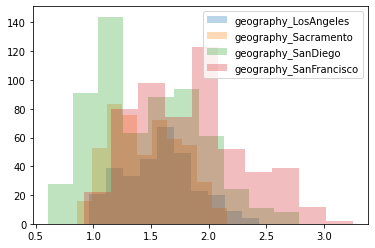

In [2340]:
plt.hist(df_new_names.query("geography_LosAngeles == 1")['average_price'], alpha = 0.3, label = 'geography_LosAngeles');
plt.hist(df_new_names.query("geography_Sacramento == 1")['average_price'], alpha = 0.3, label = 'geography_Sacramento');
plt.hist(df_new_names.query("geography_SanDiego == 1")['average_price'], alpha = 0.3, label = 'geography_SanDiego');
plt.hist(df_new_names.query("geography_SanFrancisco == 1")['average_price'], alpha = 0.3, label = 'geography_SanFrancisco');

plt.legend();

In [1114]:
df.columns


Index(['average_price', 'total_volume', '4046', '4225', '4770', 'total_bags',
       'small_bags', 'large_bags', 'xlarge_bags', 'type', 'year', 'geography',
       'month', 'intercept'],
      dtype='object')